# Introduction to Medical Image Registration using Deep Neural Networks with `DeepReg`

### Nina Montana Brown, Yunguan Fu, Shaheer U. Saeed, Zac Baum, Adria Casamitjana, Alex Grimwood, Ester Bonmati, Tom Vercauteeren, Matt Clarkson, Yipeng Hu

### Who am I missing? Affiliations?

# Table of Contents - Update
1. [Set-up](#setup)
2. [Introduction to Registration](#IntroReg)
3. [Registration with Deep Learning](#DeepRegistrationIntro)
4. [A simple non-rigid registration using Deep Learning](#third-example)
5. [MIR using a DNN](#fourth_example)
6. [References](#references)

# Objective
This tutorial introduces a new open-source project [DeepReg](https://github.com/DeepRegNet/DeepReg), which is designed to be a rookie-friendly package for researchers interested in image registration using deep learning. 

A previous MICCAI workshop [learn2reg](https://learn2reg.github.io/) provided an excelent example of novel algorithms and interesting approaches in this active research area, whilst this tutorial explores the strenghth of the simple, yet generalisable deisgn of DeepReg. 
- Explain basic concepts in medical image registration (which can also be readily implemented using DeepReg!);
- Explore the links between the classical iterative algorithms and modern algorithms using neural networks;
- Perhaps more importantly, introduce the versatile capability of DeepReg, with diverse examples in real clinical challenges.

All of this will require minimum coding expereince with DeepReg, accomanying a set of well-written documentation and a growing number of demos using real, open-accesible clinical data. This tutorial will get you started with a number of examples by step-by-step instructions.

# Set-up <a name="setup"></a>
This tutorial depends on the package [DeepReg](https://github.com/DeepRegNet/DeepReg), which in turn has external dependencies which are managed by `pip`. 

To ensure the demo'd algorithms can run from this Google Colab notebook, you will need to mount your Google Drive and clone the repository into it. You can do this by running the following commands.

You can also follow along in a local copy of the repo - in this case, follow instructions for set up at [the quickstart guide](https://github.com/DeepRegNet/DeepReg/blob/master/docs/quick_start.md).

Training DNNs is computationally expensive. We have tested this demo with GPUs provided by Google through Google Colab. Training times have been roughly measured and indicated where appropriate. You can run this on CPU but we have not tested how long it would take.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')
! pwd


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/
/content


Once the drive is mounted, ensure that you have GPU enabled for more efficient training.

To do this, go to the Edit tab on the upper left hand bar: Edit > Click on Notebook Settings > Enable GPU

In [4]:
import os
# Make a directory in your google drive namde "MICCAI_2020_reg_tutorial"
if not os.path.exists("./MICCAI_2020_reg_tutorial"):
  os.makedirs("./MICCAI_2020_reg_tutorial")
# Move into the dir
%cd ./MICCAI_2020_reg_tutorial
! pwd

/content/MICCAI_2020_reg_tutorial
/content/MICCAI_2020_reg_tutorial


In [5]:
%%capture
# Clone the DeepReg repository which contains the code
! git clone https://github.com/DeepRegNet/DeepReg.git
%cd ./DeepReg/
# pip install into the notebook env
! pip install -e .
! pip install wget
! pwd

# Introduction to Registration <a name="IntroReg"></a>

Image registration is an essential process in many clinical applications and computer assisted interventions **cite**. 

Applications of medical image registration (MIR) include - but are not limited to:
* Longitudinal comparison of images for a given patient with the same imaging modality: for example, comparing the outcome of given cancer treatment in a patients' CT scans over time. **cite**
* Inter-subject comparison: for example, population study using neuroimaging. **cite**
* Multi-modal registration for image guided surgery: for example, aligning real-time ultrasound scans to pre-operative CT or MRI scans to real-time achieve guidance in neurosurgical or abdominal applications. **cite**
* Atlas-based image segmentation: aligning new images to those carefully segmented, such that the reference segmentations can be propagated to those new images.

Image registration is the mapping of one image coordinate system to another, and can be sub-divided into rigid registrations and non-rigid registrations, depending on whether or not higher-dimesional tissue deformations is modelled as oppose to, for exmaple, a 6 degree-of-freedom (3 translational axes + 3 rotational axes) srigid transformation. Data may be aligned in many ways - spatially or temporally being two key ones.

Typically, we refer to one of the images in the pair as the *moving* image and the other as the *fixed* image. The goal is to find the *correspondence* that aligns the moving image to the fixed image - the transform will project the *moving* coordinates into the *fixed* coordinate space. The correspondence specifies the mapping between all voxels from one image to those from another image. The correspondence can be represented by a dense displacment field (DDF), defined as a set of displacement vectors for all pixels or voxels from one image to another. By using these displacement vectors, one image can be "warped" to become more "similar" to another.

Additionally, the data may have additional labels to highlight specific regions of interest (ROIs) to the clinician in the scan(s). These are typically provided as binary masks of organs that match the image dimensions, and refer to specific images or sets of images. This information can be used to constrain (or *regularise*) registration - the labels for the moving image (the *moving label*) can be warped with the predicted transformation and compared to the *fixed* label to measure the success of the registration.

Finally, the data may be *paired*. The pairing of data can be considered as an "extra" label that denotes. A clinical scenario for a paired data set would be using the inspiration and expiration end points in lung CT to match time points between subject scan registration.

Labels are useful as they can help constrain the problem to certain solutions - for example, if the predicted transformation warps the binary masks such that they are highly dissimilar, the transformation can be considered unlikely. However, labels are not always available - labelling data is costly and in some cases, not possible.



## Classical Registration Methods
Image registration has been an active area of research for decades. Historically, the so-called classical algorithms pose registration as an optimisation problem between a given pair of moving and fixed images. In these methods, a pre-defined transformation model, rigid or nonrigid, is iteratively optimised to minimise a similarty measure - a metric that quantifies how "similar" between the warped moving image and the fixed image. 

The similarity measure can be a function sampling only important image features (extracted from a pre-processing step) or directly sampling all intensity values from both images.

* **Feature-based registration**: a transformation between point clouds - vectors indicating 3D spatial information - can be estimated using Iterative Closest Point (ICP) or it's more robust variant, Global Iterative ICP (GO-ICP) **cite**. The basis of ICP is to iteratively minimise the distance between the two point clouds by matching the points from one set to the closest point in the other set. This is done by searching for the minimum Euclidean distance for each point to the other cloud(otherwise known as the L2 distance):

$$L_2 = \sqrt(\vec{x_1} - \vec{x_2})^2$$

  The transformation can be estimated from the found set of pairs, or correspondence, applying the transformation, and repeating the process many times.
* **Intensity-based registration**: Typically, medical imaging data does not come in point cloud format, but rather, 2D, 3D and 4D matrices with a range of intensity values at each pixel or voxel. As such, different measures can be used directly on the intensity distributions of the data to measure similarity between the data. Examples of measures are cross correlation, mutual information and simple sum-square-difference - these intensity-based algorithms can optimise a transformation model directly using images without the feature extraction step.

Many today's deep-learning-based methods have been heavily influnced and derived from these prior work. (You can cite Dave's book here)

## Why use Deep Learning for MIR?
Usually, classical methods are unable to handle real-time registration of large point sets or feature intensity distributions owing to their computationally intense nature, especially in the case of 3D nonrigid registration. State-of-the-art classical methods are implemented on GPU still struggle for real-time performance for many time-critical clinical applications.

Secondly, classical algorithms are inherently pairwise approaches that can not take into account population data statistics directly and relying on well-designed transformation models and valid similarity being avaialable and robust, challenging for many real-world tasks.

In contrast, the computationally efficient inference and the ability to model complex, non-linear transformations of learning-based methods has motivated the development of neural networks which infer the optimal transformation from unseen data **cite**. 

However, it is important to point out that 
* Many deep-learning-based methods are still subject to these limitations, especially those that borrow transformation models and similarity measures directly from the classical methods
* Deep learning models are limited at inference time by how the model was trained - it is well known that deep learning models can overfit to the training data.
* Classical algorithms have been refined for many clinical applications and still work really well.

# Image Registration with Deep Learning <a name="DeepRegistrationIntro"></a>

In recent years, image registration has been re-formulated as a learning problem, in which, pairs of moving and fixed images are passed to a machine learning model (usually a neural network nowadays) to predict a transformation between the images.

In this tutorial, we investigate three factors that determine a deep learning approach for image registration:

1. What type of transformation is one trying to predict?
2. What type image data are being registered? Are there any other data, such as segmentations, to support the registration?
3. Are the data paired? Are they labeled?


## Types of transformations

We need to choose what type of transformation we want to predict. 

- **Predicting a dense displacement field**

  Given a pair of moving and fixed images, a registration network
  can be trained to output dense displacement field (DDF) of the same shape as the moving image. Each value in the DDF
  can be considered as the placement of the corresponding pixel / voxel of the moving
  image. Therefore, the DDF defines a mapping from the moving image's coordinates to the
  fixed image.

  In this tutorial, we mainly focus on DDF-based methods.

- **Predict a dense velocity field**

  Another option is to predict a dense velocity field (DVF) between a pair of images, such that a diffeomorphic
  DDF can be numerically integrated. Read
  ["A fast diffeomorphic image registration algorithm"](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.474.1033&rep=rep1&type=pdf)
  for more details.

- **Predict an affine transformation**

  A more constrained option is to predict an affine transformation, parameterised the
  affine transformation matrix of 12 degrees of freedom. The DDF can then be computed to
  resample the moving images in fixed image space.

- **Predict a region of interest**

  Instead of outputting the transformation between coordinates, given moving image,
  fixed image, and a region of interest (ROI) in the moving image, the network can
  predict the ROI in fixed image directly. Interested readers are referred to the MICCAI
  2019 paper:
  [Conditional segmentation in lieu of image registration](https://arxiv.org/abs/1907.00438).


## Data availability - level of supervision + network design

Depending on the availability of the data labels, registration networks can be trained
with different approaches. These will influence our loss choice.

### Unsupervised

When the data label is unavailable, training can be achieved via an unsupervised loss.
The
following is an illustration of an unsupervised DDF-based registration network.

![Unsupervised DDF-based registration network](https://deepregnet.github.io/DeepReg/asset/registration-ddf-nn-unsupervised.svg)

The loss function often consists of the intensity based loss and deformation loss.

### Weakly-supervised

When there is no intensity based loss that is appropriate for the image pair one would
like to register, the training can take a pair of corresponding moving and fixed labels
(in addition to the image pair), represented by binary masks, to compute a label
dissimilarity (feature based loss) to drive the registration.

Combined with the regularisation on the predicted displacement field, this forms a
weakly-supervised training. An illustration of an weakly-supervised DDF-based
registration network is provided below.

When multiple labels are available for each image, the labels can be sampled during
training iteration, such that only one label per image is used in each iteration of the
data set (epoch). Read [data sampling API](tutorial_sampling.md) for more details.

![Weakly-supervised DDF-based registration network](https://deepregnet.github.io/DeepReg/asset/registration-ddf-nn-weakly-supervised.svg)

### Combined

When the data label is available, combining intensity based, feature based, and
deformation based losses together has shown superior registration accuracy, compared to
unsupervised and weakly supervised methods. Following is an illustration of a combined
DDF-based registration network.

![Combined DDF-based registration network](https://deepregnet.github.io/DeepReg/asset/registration-ddf-nn-combined.svg)

## Loss functions

We aim to train a network to predict some transformation between a pair of images that is likely. To do this, we need to define what is a "likely" transformation. This is done via a *loss function*.

The loss function defined to train a registration network will depend on the type of data we have access to.

- **Intensity based (image based) loss**

  This type of loss measures the dissimilarity of the fixed image and warped moving
  image, which is adapted from the classical image registration methods. Intensity based
  loss is modality-independent and similar to many other well-studied computer vision
  and medical imaging tasks, such as image segmentation.

  The common loss functions are normalized cross correlation (NCC), sum of squared
  distance (SSD), and normalized mutual information (MI).

- **Feature based (label based) loss**

  Provided labels for the input images, a feature based loss may be used to measure the (dis)similarity of warped regions of interest. Having computed a transformation between images using the net, one of the labels is warped and compared to the ground truth image label.
 Labels are typically manually contoured organs.

  The common loss function is Dice loss, Jacard and average cross-entropy over all
  voxels, which are measures of the overlap of the ROIs. The loss will minimise the negative overlap measure (eg. l = 1 - dice_score) to maximise overlap of the regions during training.

- **Deformation loss**

  Additionally, training may be regularised by computing the "likelihood" of a given displacement field. High deformation losses point to very unlikely displacement due to high gradients of the field - typically, deformation losses ensure smoothness in the displacement field. For DDFs, typical regularisation losses are bending energy losses, L1 or L2 norms of the displacement gradients.


# Image Registration with Deep Learning: Summary <a name="DeepRegistrationIntro"></a>

For deep learning methods, pairs of images, denoted as moving
and fixed images, are passed to the network to predict a transformation between the images.

The deep learning approach for MIR will depend on mainly three factors:

1. What type of transformation is one trying to predict?
2. What type image data are being registered? Are there any other data, such as segmentations, to support the registration?
3. Are the data paired? Are they labeled?

From this, we can design an appropriate architecture and choose an adequate loss function to motivate training.

# Optimising a global transformation from a single pair of images - the classical registration algorithms

We will define a single layer example using functions from DeepReg, and train it to register two images.

This demo uses head and neck CT scans data from **where is this data from.**

First, we will illustrate the possibility of "self-registering" an image to it's affine-transformed counterpart.

[//]:# "you might want to make it consistent as `deformation` is often refered to as a nonrigid subset of the general `transformation`"

Then, we will register two subjects' scans (inter-subject registration).

## Learning an affine transformation: "self-registration"

In [57]:
# We import some utility modules.
import nibabel
import tensorflow as tf 
import deepreg.model.layer as layer
import deepreg.model.loss.image as image_loss
import deepreg.model.loss.deform as deform_loss
import deepreg.model.layer_util as layer_util
import matplotlib.pyplot as plt
import os
import h5py
from tensorflow.keras.utils import get_file

# We set the plot size to some parameters.
plt.rcParams["figure.figsize"] = (100,100)

In [48]:
# We define some utility functions first
## optimisation
@tf.function
def train_step_CT(grid, weights, optimizer, mov, fix):
    """
    Train step function for backprop using gradient tape
    :param grid: reference grid return from util.get_reference_grid
    :param weights: trainable affine parameters [1, 4, 3]
    :param optimizer: tf.optimizers
    :param mov: moving image [1, m_dim1, m_dim2, m_dim3]
    :param fix: fixed image [1, f_dim1, f_dim2, f_dim3]
    :return loss: image dissimilarity to minimise
    """
    with tf.GradientTape() as tape:
        pred = layer_util.resample(vol=mov, loc=layer_util.warp_grid(grid, weights))
        loss = image_loss.dissimilarity_fn(
            y_true=fix, y_pred=pred, name=image_loss_name
        )
    gradients = tape.gradient(loss, [weights])
    optimizer.apply_gradients(zip(gradients, [weights]))
    return loss

def plot_results(moving_image, fixed_image, warped_moving_image, nIdx):
  """
  Plotting the results from training
  :param moving_image: [IM_SIZE_0, IM_SIZE_1, 3]
  :param fixed_image:  [IM_SIZE_0, IM_SIZE_1, 3]
  :param warped_moving_image:  [IM_SIZE_0, IM_SIZE_1, 3]
  :param nIdx: number of indices to display
  """
  # Display
  plt.figure()
  for idx in range(nIdx):
      axs = plt.subplot(nIdx, 3, 3 * idx + 1)
      axs.imshow(moving_image[0, ..., idx_slices[idx]], cmap="gray")
      axs.axis("off")
      axs = plt.subplot(nIdx, 3, 3 * idx + 2)
      axs.imshow(fixed_image[0, ..., idx_slices[idx]], cmap="gray")
      axs.axis("off")
      axs = plt.subplot(nIdx, 3, 3 * idx + 3)
      axs.imshow(warped_moving_image[0, ..., idx_slices[idx]], cmap="gray")
      axs.axis("off")
  plt.ion()
  plt.suptitle('Moving Image - Fixed Image - Warped Moving Image', fontsize=200)
  plt.show()

def display(moving_image, fixed_image):
  """
  Displaying our two image tensors to register
  :param moving_image: [IM_SIZE_0, IM_SIZE_1, 3]
  :param fixed_image:  [IM_SIZE_0, IM_SIZE_1, 3]
  """
  # Display
  idx_slices = [int(5+x*5) for x in range(int(fixed_image_size[3]/5)-1)]
  nIdx = len(idx_slices)
  plt.figure()
  for idx in range(len(idx_slices)):
      axs = plt.subplot(nIdx, 2, 2*idx+1)
      axs.imshow(moving_image[0,...,idx_slices[idx]], cmap='gray')
      axs.axis('off')
      axs = plt.subplot(nIdx, 2, 2*idx+2)
      axs.imshow(fixed_image[0,...,idx_slices[idx]], cmap='gray')
      axs.axis('off')
  plt.suptitle('Moving Image - Fixed Image', fontsize=200)
  plt.show()

In [37]:
# We download the data first
MAIN_PATH = os.getcwd()
PROJECT_DIR = os.path.join(MAIN_PATH, "demos/classical_ct_headandneck_affine")

DATA_PATH = "dataset"
FILE_PATH = os.path.abspath(os.path.join(PROJECT_DIR, DATA_PATH, "demo.h5"))
ORIGIN = "https://github.com/YipengHu/example-data/raw/master/hnct/demo.h5"

if os.path.exists(FILE_PATH):
    os.remove(FILE_PATH)
else:
  os.makedirs(os.path.join(PROJECT_DIR, DATA_PATH))
get_file(FILE_PATH, ORIGIN)
print("CT head-and-neck data downloaded: %s." % FILE_PATH)


2433024/2426880 [==============================] - 0s 0us/step
CT head-and-neck data downloaded: /content/MICCAI_2020_reg_tutorial/DeepReg/demos/classical_ct_headandneck_affine/dataset/demo.h5.


Step 0 ssd [0.0122252209]
Step 50 ssd [0.00405526254]
Step 100 ssd [0.00355573]
Step 150 ssd [0.00354977837]
Step 200 ssd [0.00354923517]
Step 250 ssd [0.00354896043]
Step 300 ssd [0.00355181331]
Step 350 ssd [0.00354895764]
Step 400 ssd [0.00354872085]
Step 450 ssd [0.00354869105]
Step 500 ssd [0.00354867685]
Step 550 ssd [0.00354867]
Step 600 ssd [0.00354866474]
Step 650 ssd [0.00354866311]
Step 700 ssd [0.00354866451]
Step 750 ssd [0.00356312422]
Step 800 ssd [0.00354877929]
Step 850 ssd [0.00354866521]
Step 900 ssd [0.00354867615]
Step 950 ssd [0.00356422248]


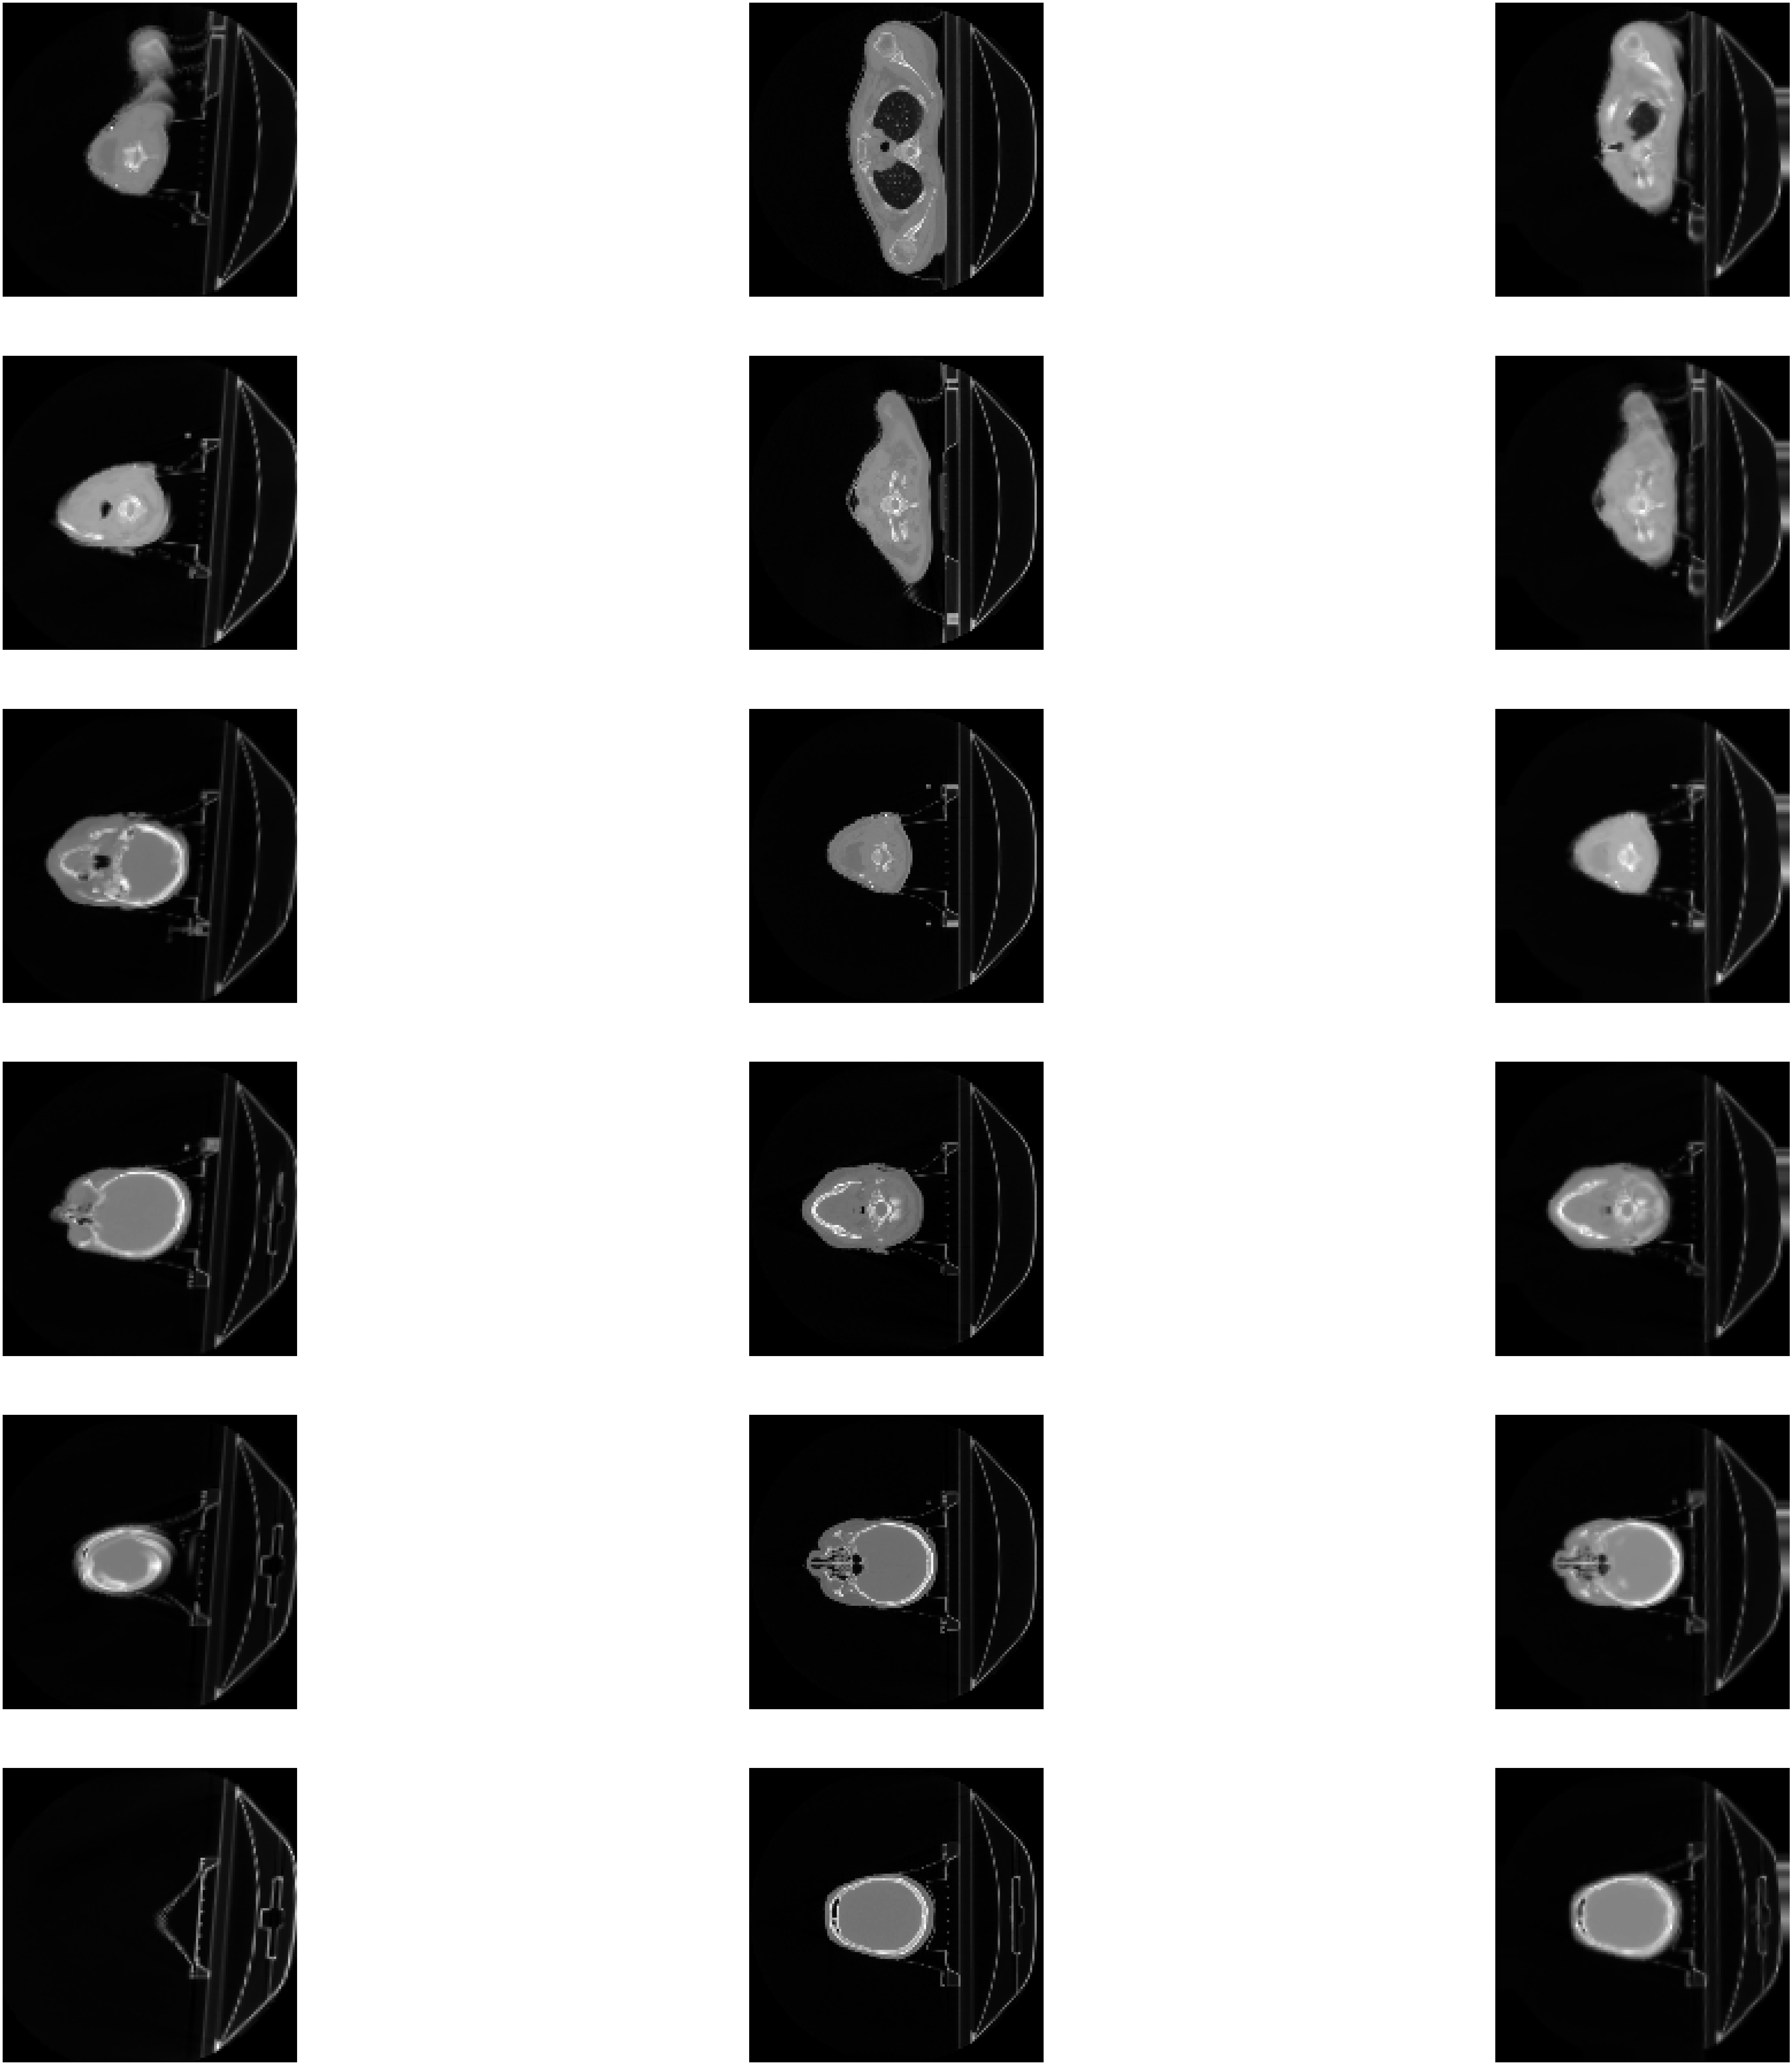

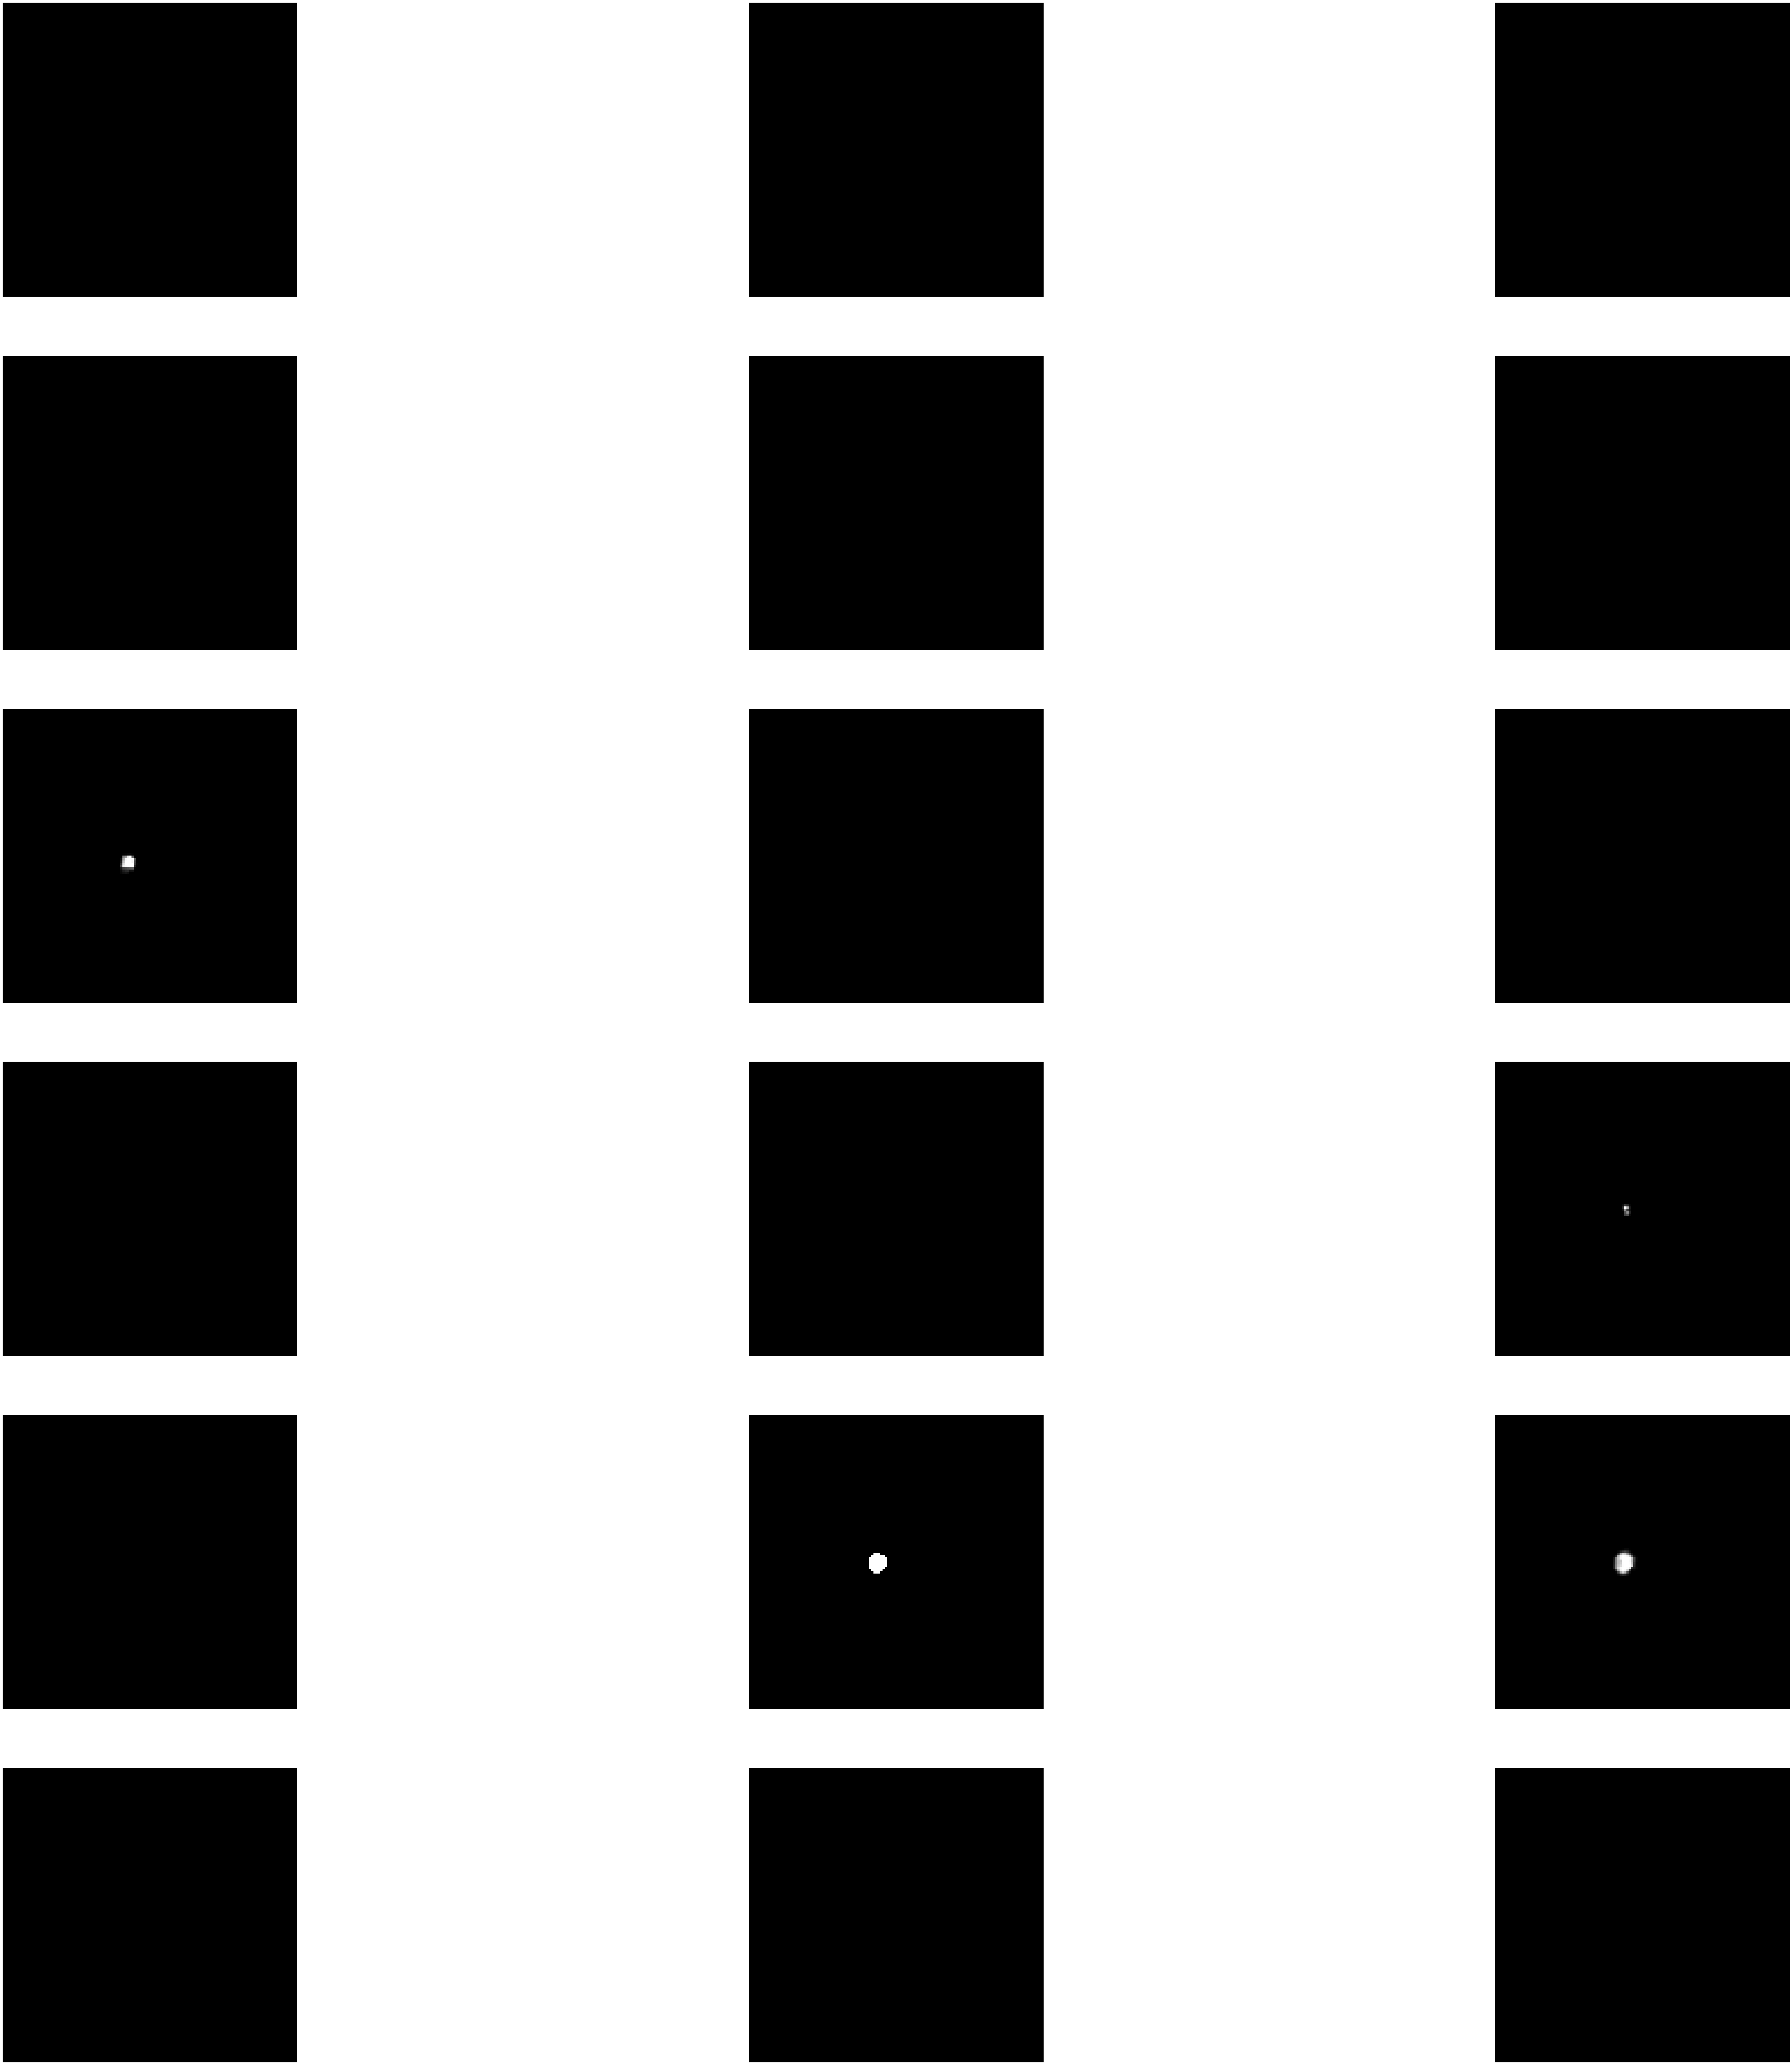

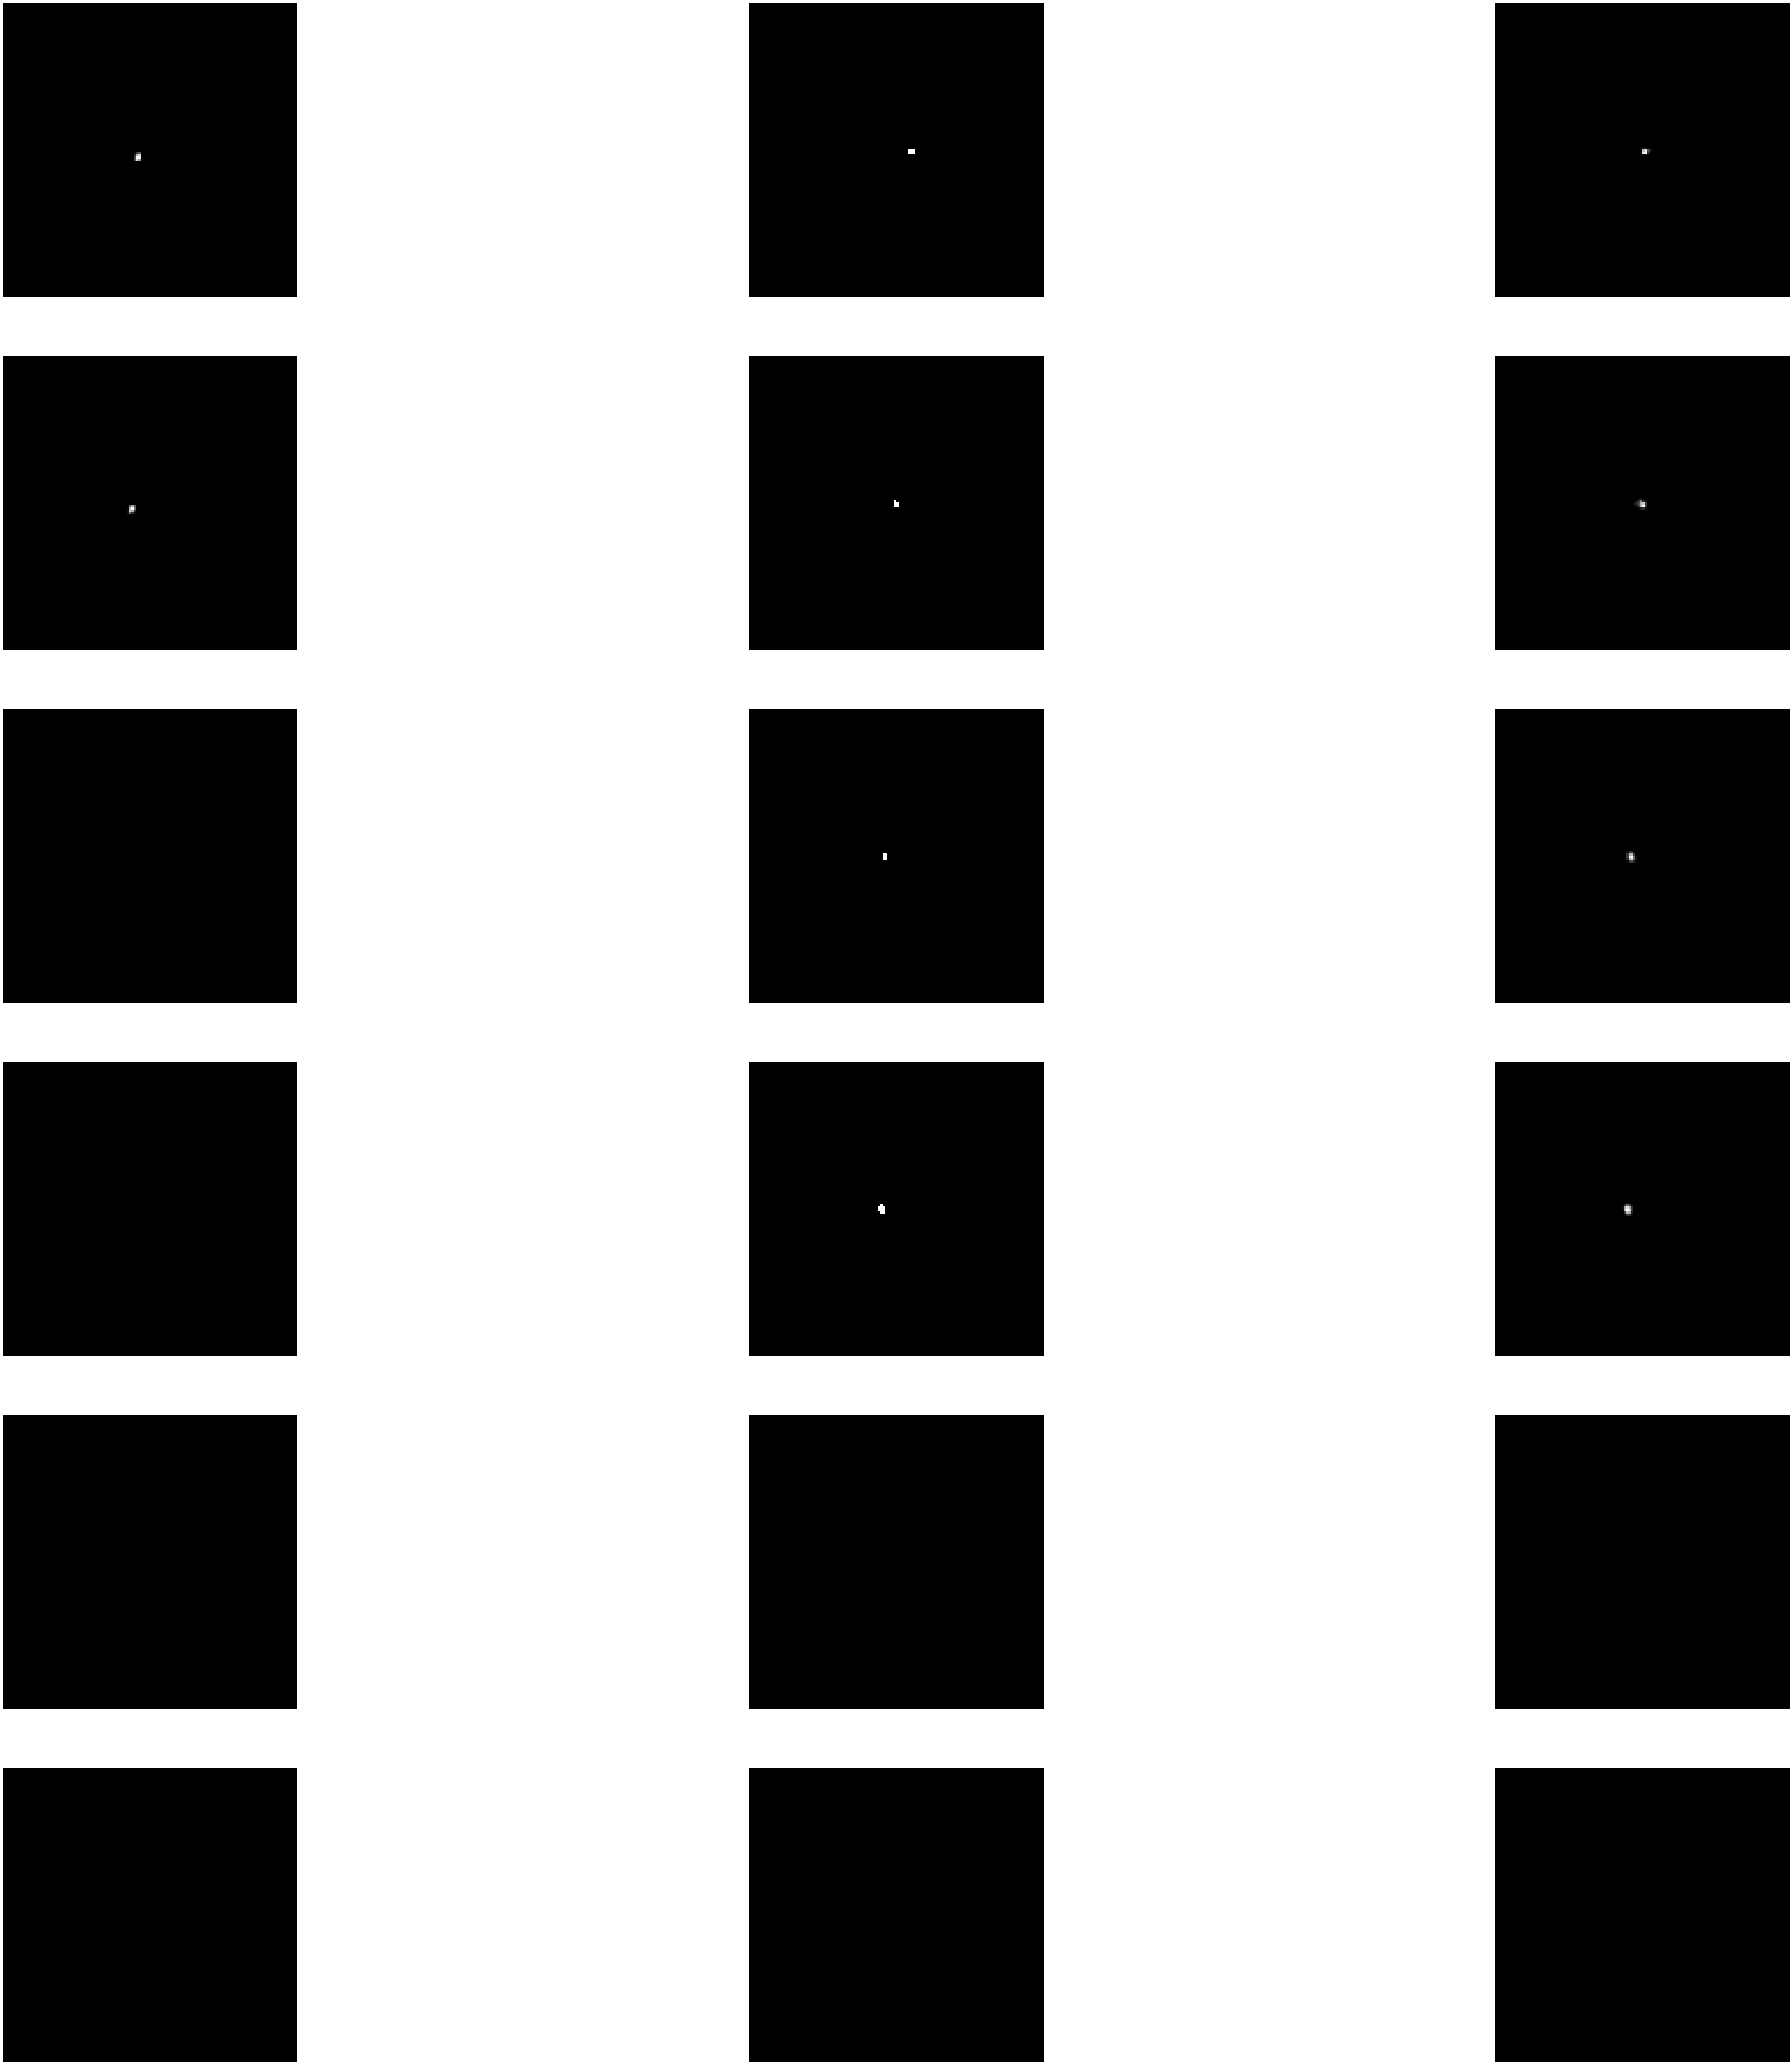

In [42]:
## registration parameters
image_loss_name = "ssd"
learning_rate = 0.01
total_iter = int(1000)


# Opening the file
fid = h5py.File(FILE_PATH, "r")
fixed_image = tf.cast(tf.expand_dims(fid["image"], axis=0), dtype=tf.float32)

# normalisation to [0,1]
fixed_image = (fixed_image - tf.reduce_min(fixed_image)) / (
    tf.reduce_max(fixed_image) - tf.reduce_min(fixed_image)
)  

# generate a radomly-affine-transformed moving image using DeepReg utils
fixed_image_size = fixed_image.shape
transform_random = layer_util.random_transform_generator(batch_size=1, scale=0.2)

grid_ref = layer_util.get_reference_grid(grid_size=fixed_image_size[1:4])

grid_random = layer_util.warp_grid(grid_ref, transform_random)
moving_image = layer_util.resample(vol=fixed_image, loc=grid_random)

# warp the labels to get ground-truth using the same random affine, for validation
fixed_labels = tf.cast(tf.expand_dims(fid["label"], axis=0), dtype=tf.float32)
moving_labels = tf.stack(
    [
        layer_util.resample(vol=fixed_labels[..., idx], loc=grid_random)
        for idx in range(fixed_labels.shape[4])
    ],
    axis=4,
)


# affine transformation as trainable weights
var_affine = tf.Variable(
    initial_value=[
        [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 0.0]]
    ],
    trainable=True,
)

# Optimising
optimiser = tf.optimizers.Adam(learning_rate)
for step in range(total_iter):
    loss_opt = train_step_CT(grid_ref, var_affine, optimiser, moving_image, fixed_image)
    if (step % 50) == 0:  # print info
        tf.print("Step", step, image_loss_name, loss_opt)

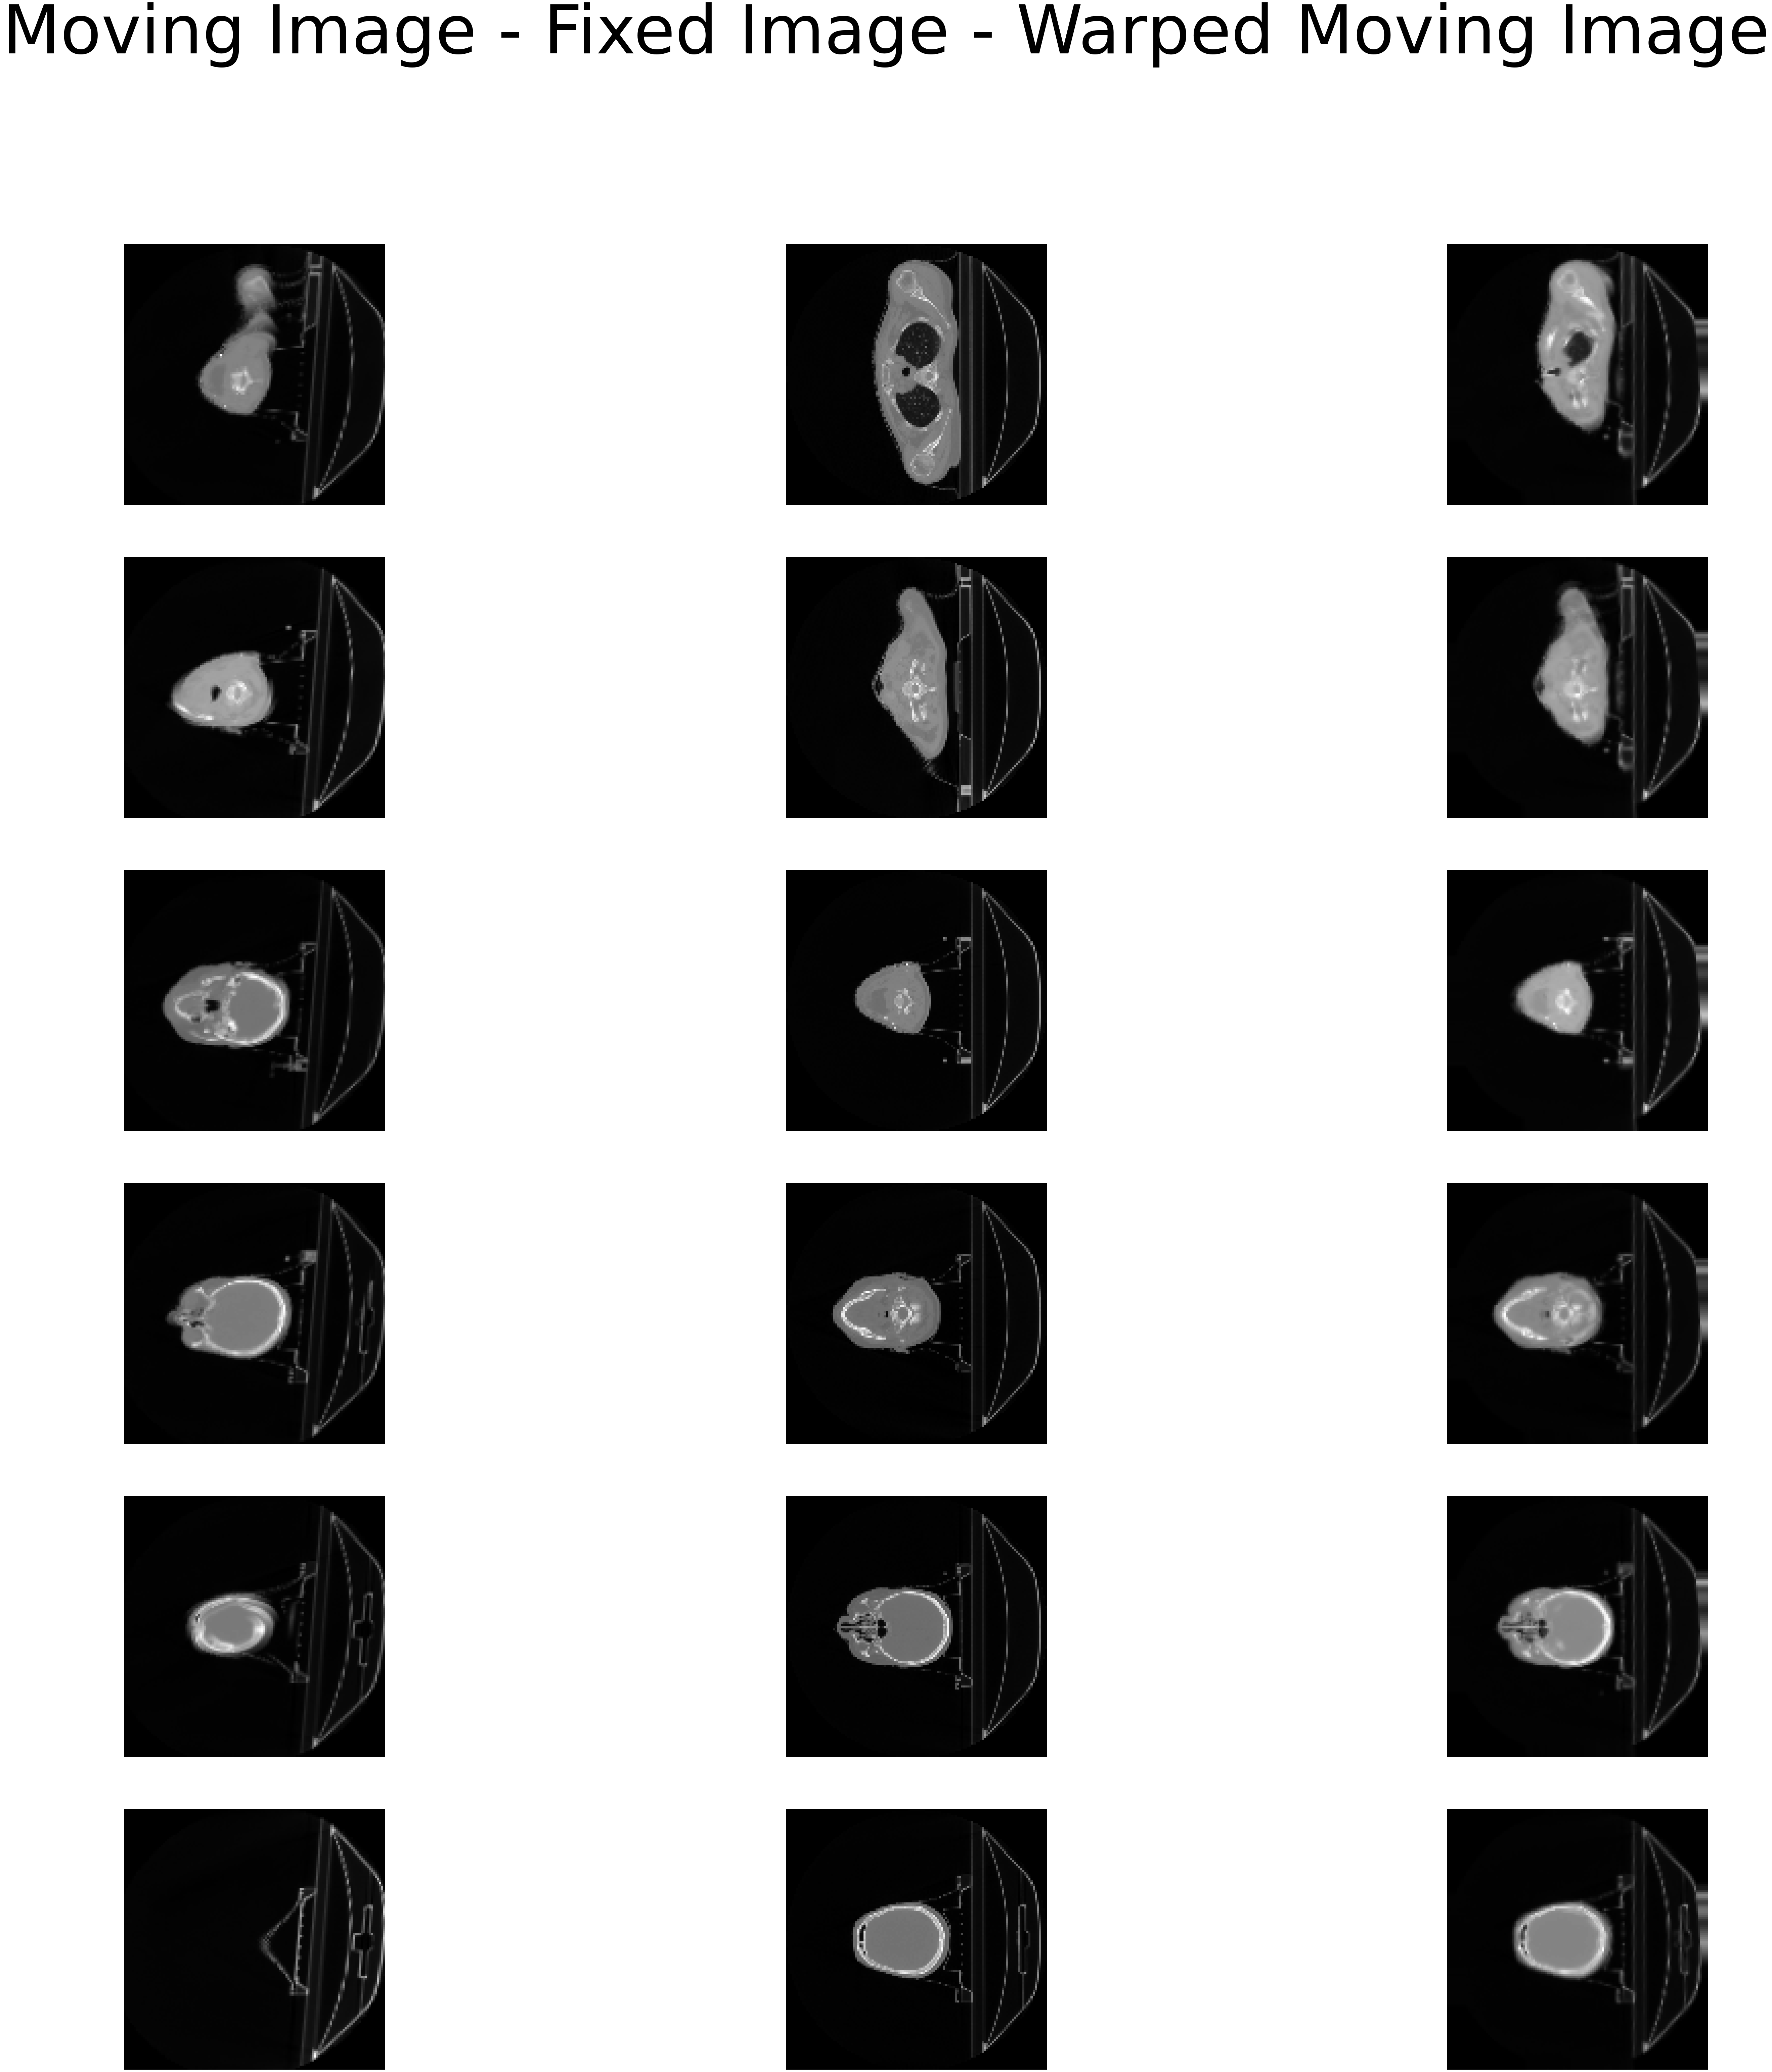

In [49]:
## warp the moving image using the optimised affine transformation
grid_opt = layer_util.warp_grid(grid_ref, var_affine)
warped_moving_image = layer_util.resample(vol=moving_image, loc=grid_opt)

idx_slices = [int(5 + x * 5) for x in range(int(fixed_image_size[3] / 5) - 1)]
nIdx = len(idx_slices)
# display
plot_results(moving_image, fixed_image, warped_moving_image, nIdx)

We can see especially from the first two slices how the data has registered to the fixed image. Let's see how the transformation appears on the labels.

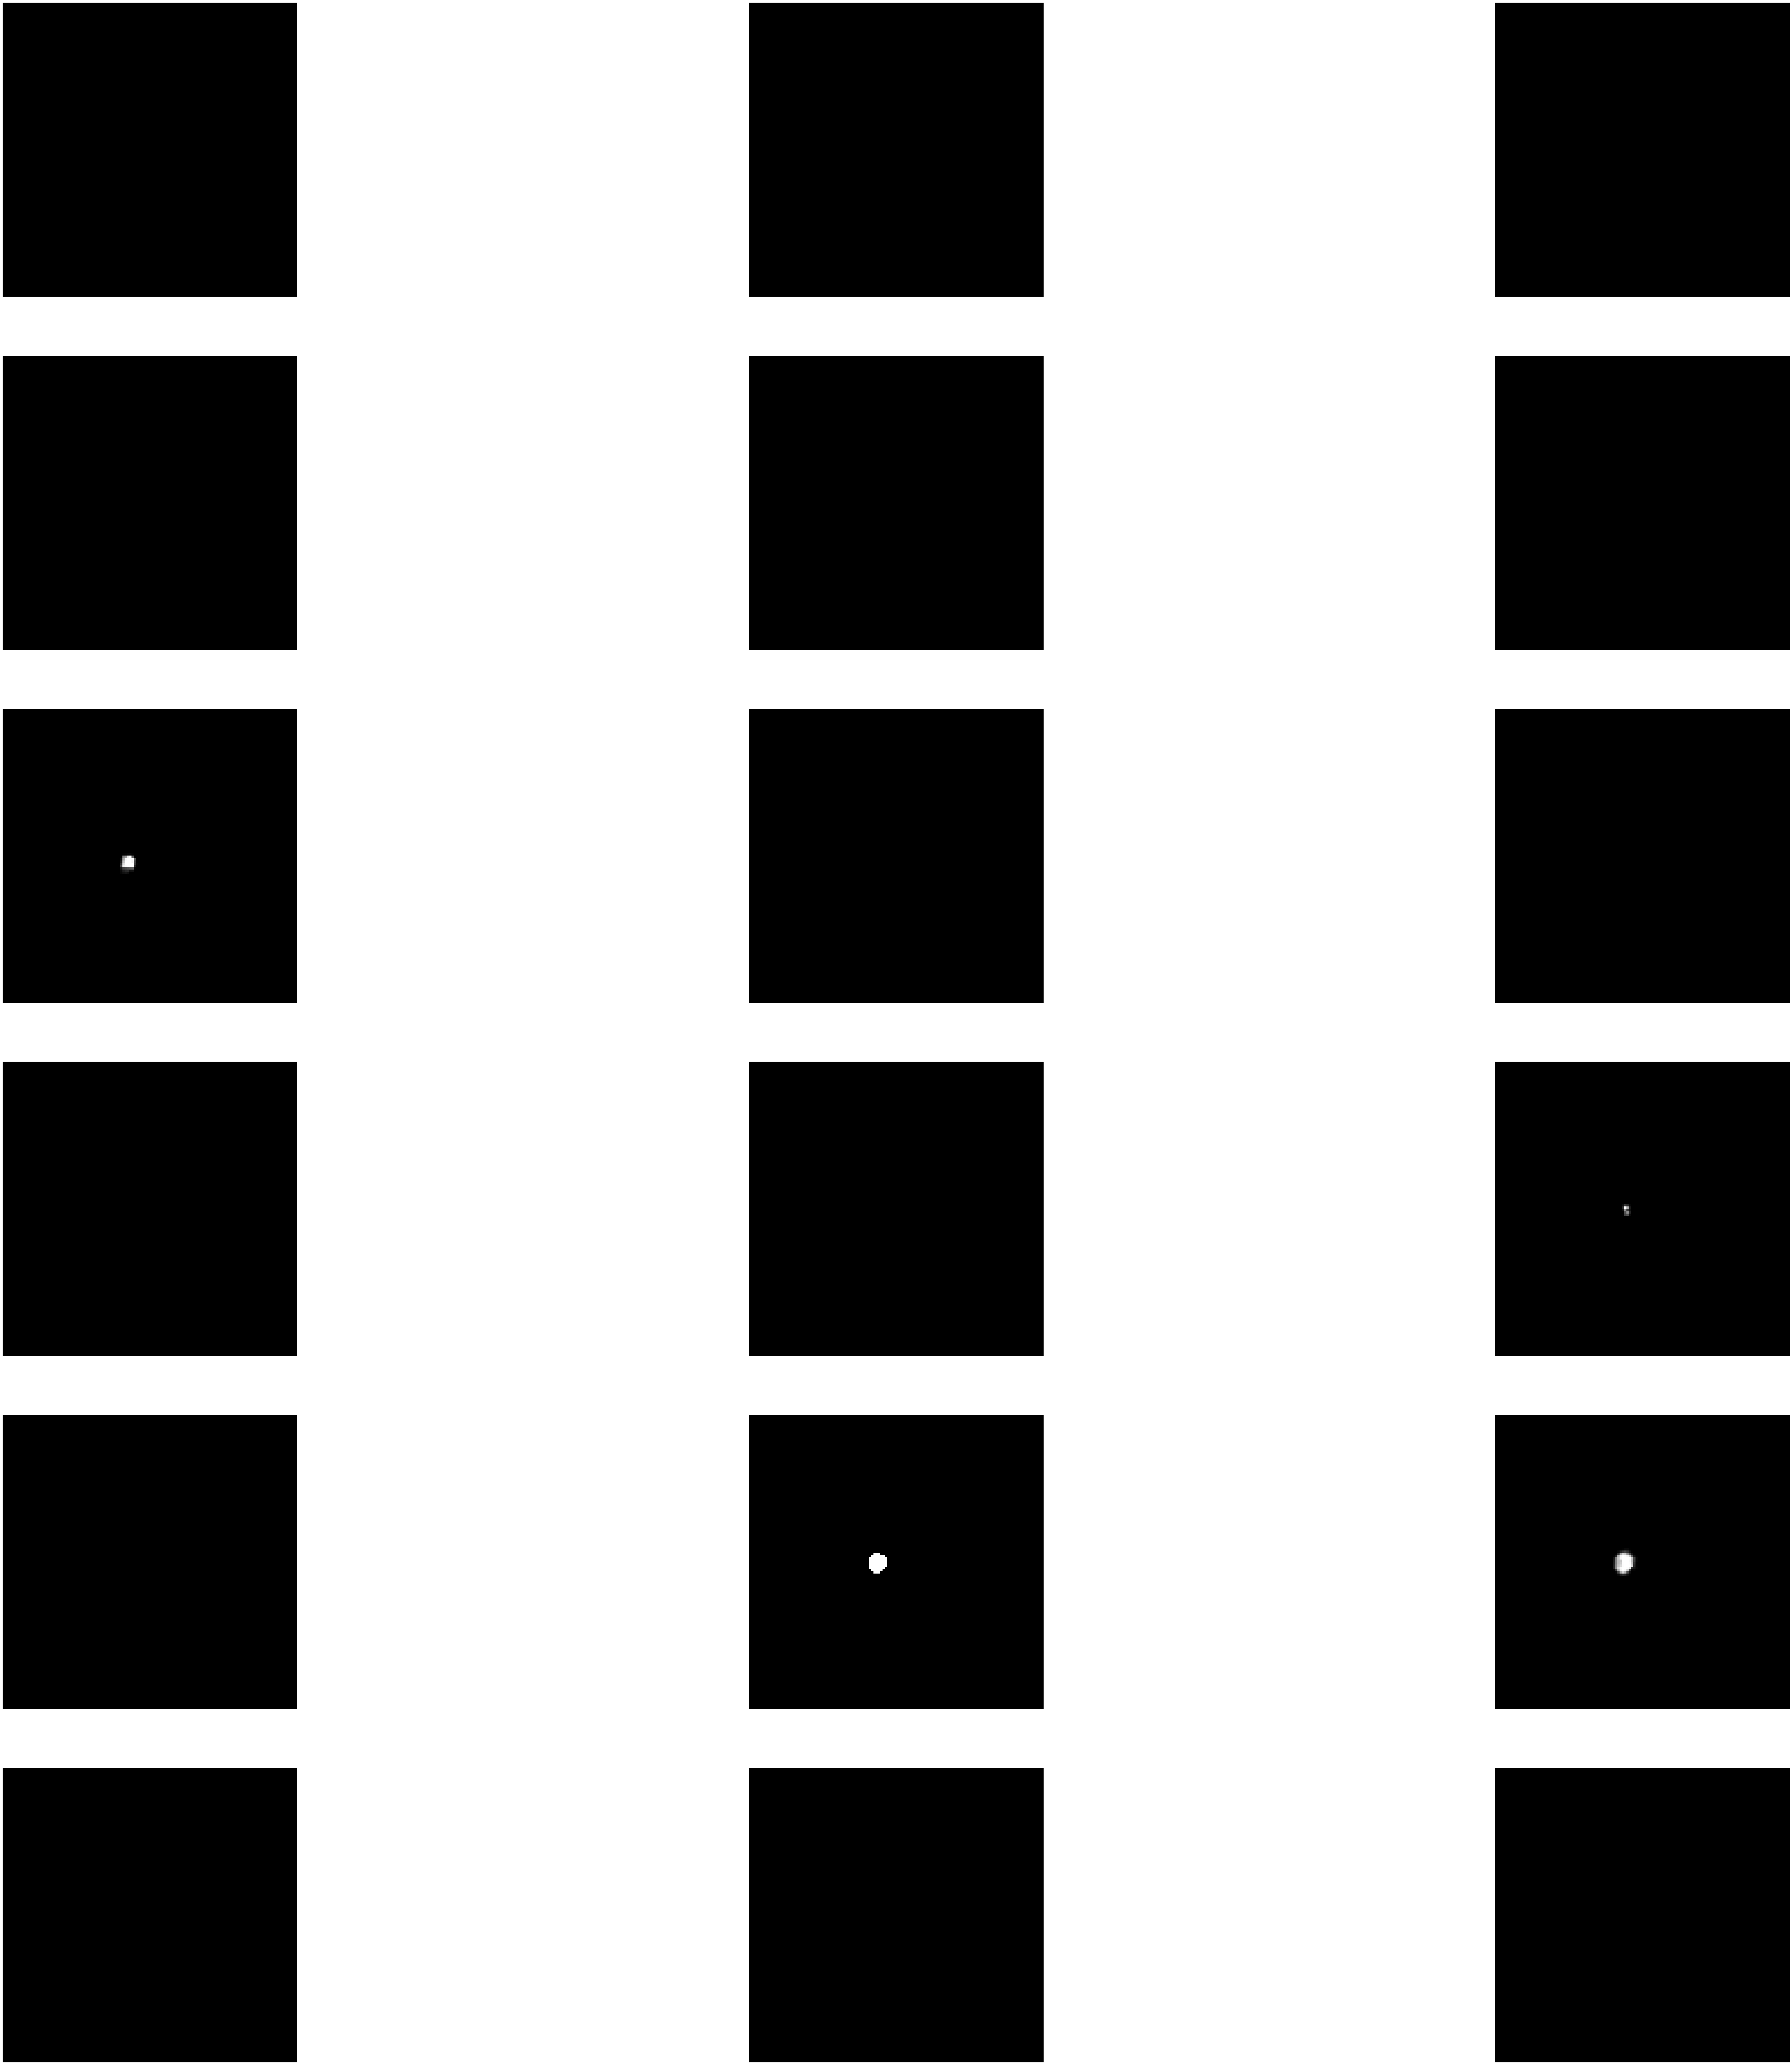

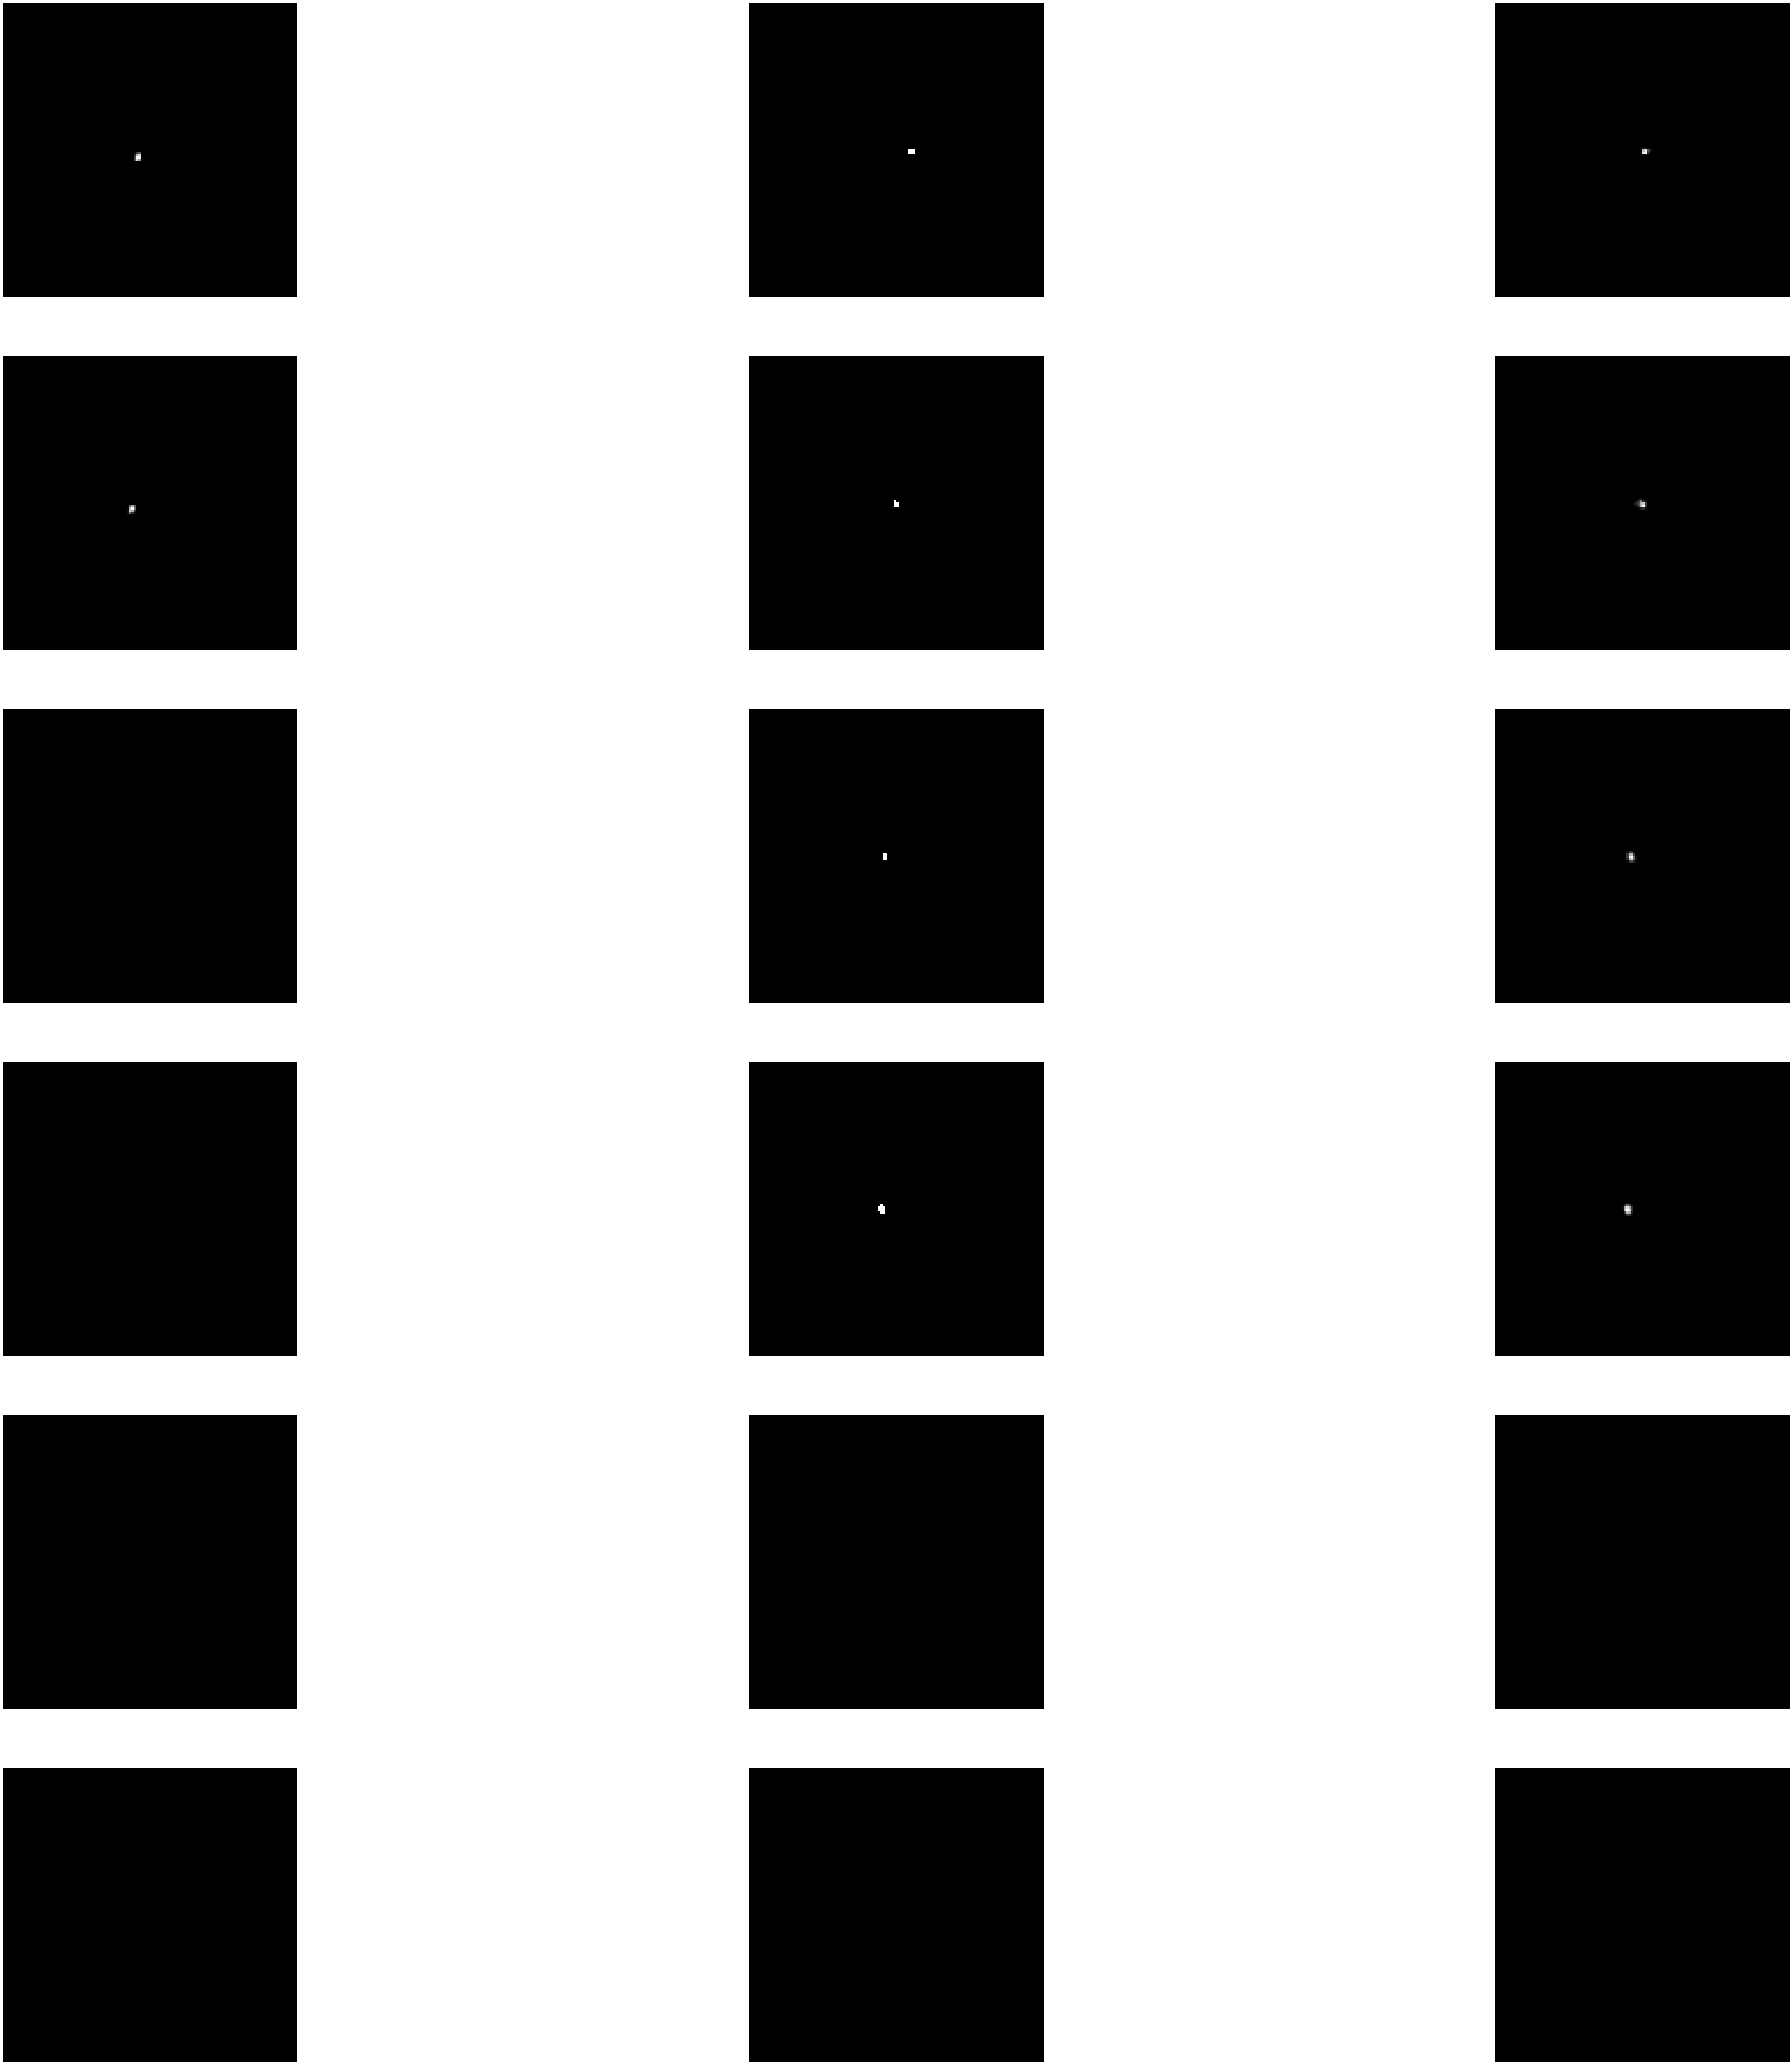

In [52]:
# Check how the labels have been registered
warped_moving_labels  = layer_util.resample(vol=moving_labels, loc=grid_opt)

# display
for idx_label in range(fixed_labels.shape[4]):
    plt.figure()
    for idx in range(len(idx_slices)):
        axs = plt.subplot(nIdx, 3, 3 * idx + 1)
        axs.imshow(moving_labels[0, ..., idx_slices[idx], idx_label], cmap="gray")
        axs.axis("off")
        axs = plt.subplot(nIdx, 3, 3 * idx + 2)
        axs.imshow(fixed_labels[0, ..., idx_slices[idx], idx_label], cmap="gray")
        axs.axis("off")
        axs = plt.subplot(nIdx, 3, 3 * idx + 3)
        axs.imshow(
            warped_moving_labels[0, ..., idx_slices[idx], idx_label], cmap="gray"
        )
        axs.axis("off")
    plt.ion()
    plt.show()

Here we can see how in some instances there is a label in the warped moving image versus the original moving image. This is an instance of conditional segmentation.

# Learning an affine transformation: inter-subject registration.

In [62]:
# Defining some utility functions
@tf.function
def train_step(warper, weights, optimizer, mov, fix):
    """
    Train step function for backpropagation using gradient tape

    :param warper: warping function returned from layer.Warping
    :param weights: trainable ddf [1, f_dim1, f_dim2, f_dim3, 3]
    :param optimizer: tf.optimizers
    :param mov: moving image [1, m_dim1, m_dim2, m_dim3]
    :param fix: fixed image [1, f_dim1, f_dim2, f_dim3]
    :return:
        loss: overall loss to optimise
        loss_image: image dissimilarity
        loss_deform: deformation regularisation
    """
    with tf.GradientTape() as tape:
        pred = warper(inputs=[weights, mov])
        # Calculating the image loss between the ground truth and prediction
        loss_image = image_loss.dissimilarity_fn(
            y_true=fix, y_pred=pred, name=image_loss_name
        )
        # We calculate the deformation loss
        loss_deform = deform_loss.local_displacement_energy(weights, deform_loss_name)
        # Total loss is weighted
        loss = loss_image + weight_deform_loss * loss_deform
    # We calculate the gradients by backpropagating the loss to the trainable layer,
    # which for registration is our ddf
    gradients = tape.gradient(loss, [weights])
    # Using our tf optimizer, we apply the gradients
    optimizer.apply_gradients(zip(gradients, [weights]))
    return loss, loss_image, loss_deform

In [66]:
## We download the data for this example.
MAIN_PATH = os.getcwd()

DATA_PATH = "dataset"
if not os.path.exists(os.path.join(MAIN_PATH, DATA_PATH)):
  os.makedirs(os.path.join(MAIN_PATH, DATA_PATH))

FILE_PATH = os.path.abspath(os.path.join(MAIN_PATH, DATA_PATH, "demo2.h5"))
ORIGIN = "https://github.com/YipengHu/example-data/raw/master/promise12/demo2.h5"

get_file(FILE_PATH, ORIGIN)
print("Prostate MR data downloaded: %s." % FILE_PATH)

os.chdir(MAIN_PATH)

DATA_PATH = "dataset"
FILE_PATH = os.path.join(MAIN_PATH, DATA_PATH, "demo2.h5")

fid = h5py.File(FILE_PATH, "r")

Prostate MR data downloaded: /content/MICCAI_2020_reg_tutorial/DeepReg/dataset/demo2.h5.


In [67]:
## We define some registration parameters
image_loss_name = "lncc" # local normalised cross correlation loss between images
deform_loss_name = "bending" # Loss to measure the bending energy of the ddf
weight_deform_loss = 10 # we weight the deformation loss
learning_rate = 0.1
total_iter = int(3000) # This will train for longer

In [68]:
# We get our two subject images from our datasets
moving_image = tf.cast(tf.expand_dims(fid["image0"], axis=0), dtype=tf.float32)
fixed_image = tf.cast(tf.expand_dims(fid["image1"], axis=0), dtype=tf.float32)

In [69]:
# We initialise our layers
fixed_image_size = fixed_image.shape

# Creating our DDF tensor that can be trained
# The DDF will be of shape [IM_SIZE_1, IM_SIZE_2, 3],
# representing the displacement field at each dimension.
var_ddf = tf.Variable(initialiser(fixed_image_size + [3]), name="ddf", trainable=True)

# We create a warping layer and initialise an optimizer
warping = layer.Warping(fixed_image_size=fixed_image_size[1:4])
optimiser = tf.optimizers.Adam(learning_rate)


## Training the layer
## With GPU this takes about 5 minutes.
for step in range(total_iter):
    # Call the gradient tape function
    loss_opt, loss_image_opt, loss_deform_opt = train_step(
        warping, var_ddf, optimiser, moving_image, fixed_image
    )
    if (step % 50) == 0:  # print info at every 50th step
        tf.print(
            "Step",
            step,
            "loss",
            loss_opt,
            image_loss_name,
            loss_image_opt,
            deform_loss_name,
            loss_deform_opt,
        )
        # Visualising loss during training
        # plt.figure()
        # fig, axs = plt.subplots(1, 3)
        # warped_moving_image = warping(inputs=[var_ddf, moving_image])
        # axs[0].imshow(moving_image[0, ..., 12])
        # axs[1].imshow(fixed_image[0, ..., 12])
        # axs[2].imshow(warped_moving_image[0, ..., 12])
        # plt.show()

Step 0 loss [-0.178768471] lncc [-0.178794637] bending [2.61643595e-06]
Step 50 loss [-0.261437774] lncc [-0.306135923] bending [0.00446981471]
Step 100 loss [-0.287059039] lncc [-0.342930853] bending [0.00558718108]
Step 150 loss [-0.300468802] lncc [-0.362231374] bending [0.00617625611]
Step 200 loss [-0.309959769] lncc [-0.375999868] bending [0.00660400838]
Step 250 loss [-0.316531718] lncc [-0.385578036] bending [0.00690463185]
Step 300 loss [-0.320564181] lncc [-0.391658127] bending [0.00710939523]
Step 350 loss [-0.323397875] lncc [-0.396059364] bending [0.00726615032]
Step 400 loss [-0.325596154] lncc [-0.399687886] bending [0.007409174]
Step 450 loss [-0.3273395] lncc [-0.402527] bending [0.00751875108]
Step 500 loss [-0.329047769] lncc [-0.405353487] bending [0.00763057265]
Step 550 loss [-0.331079036] lncc [-0.408713162] bending [0.00776341185]
Step 600 loss [-0.332478374] lncc [-0.411039978] bending [0.00785616]
Step 650 loss [-0.333222866] lncc [-0.412474781] bending [0.007

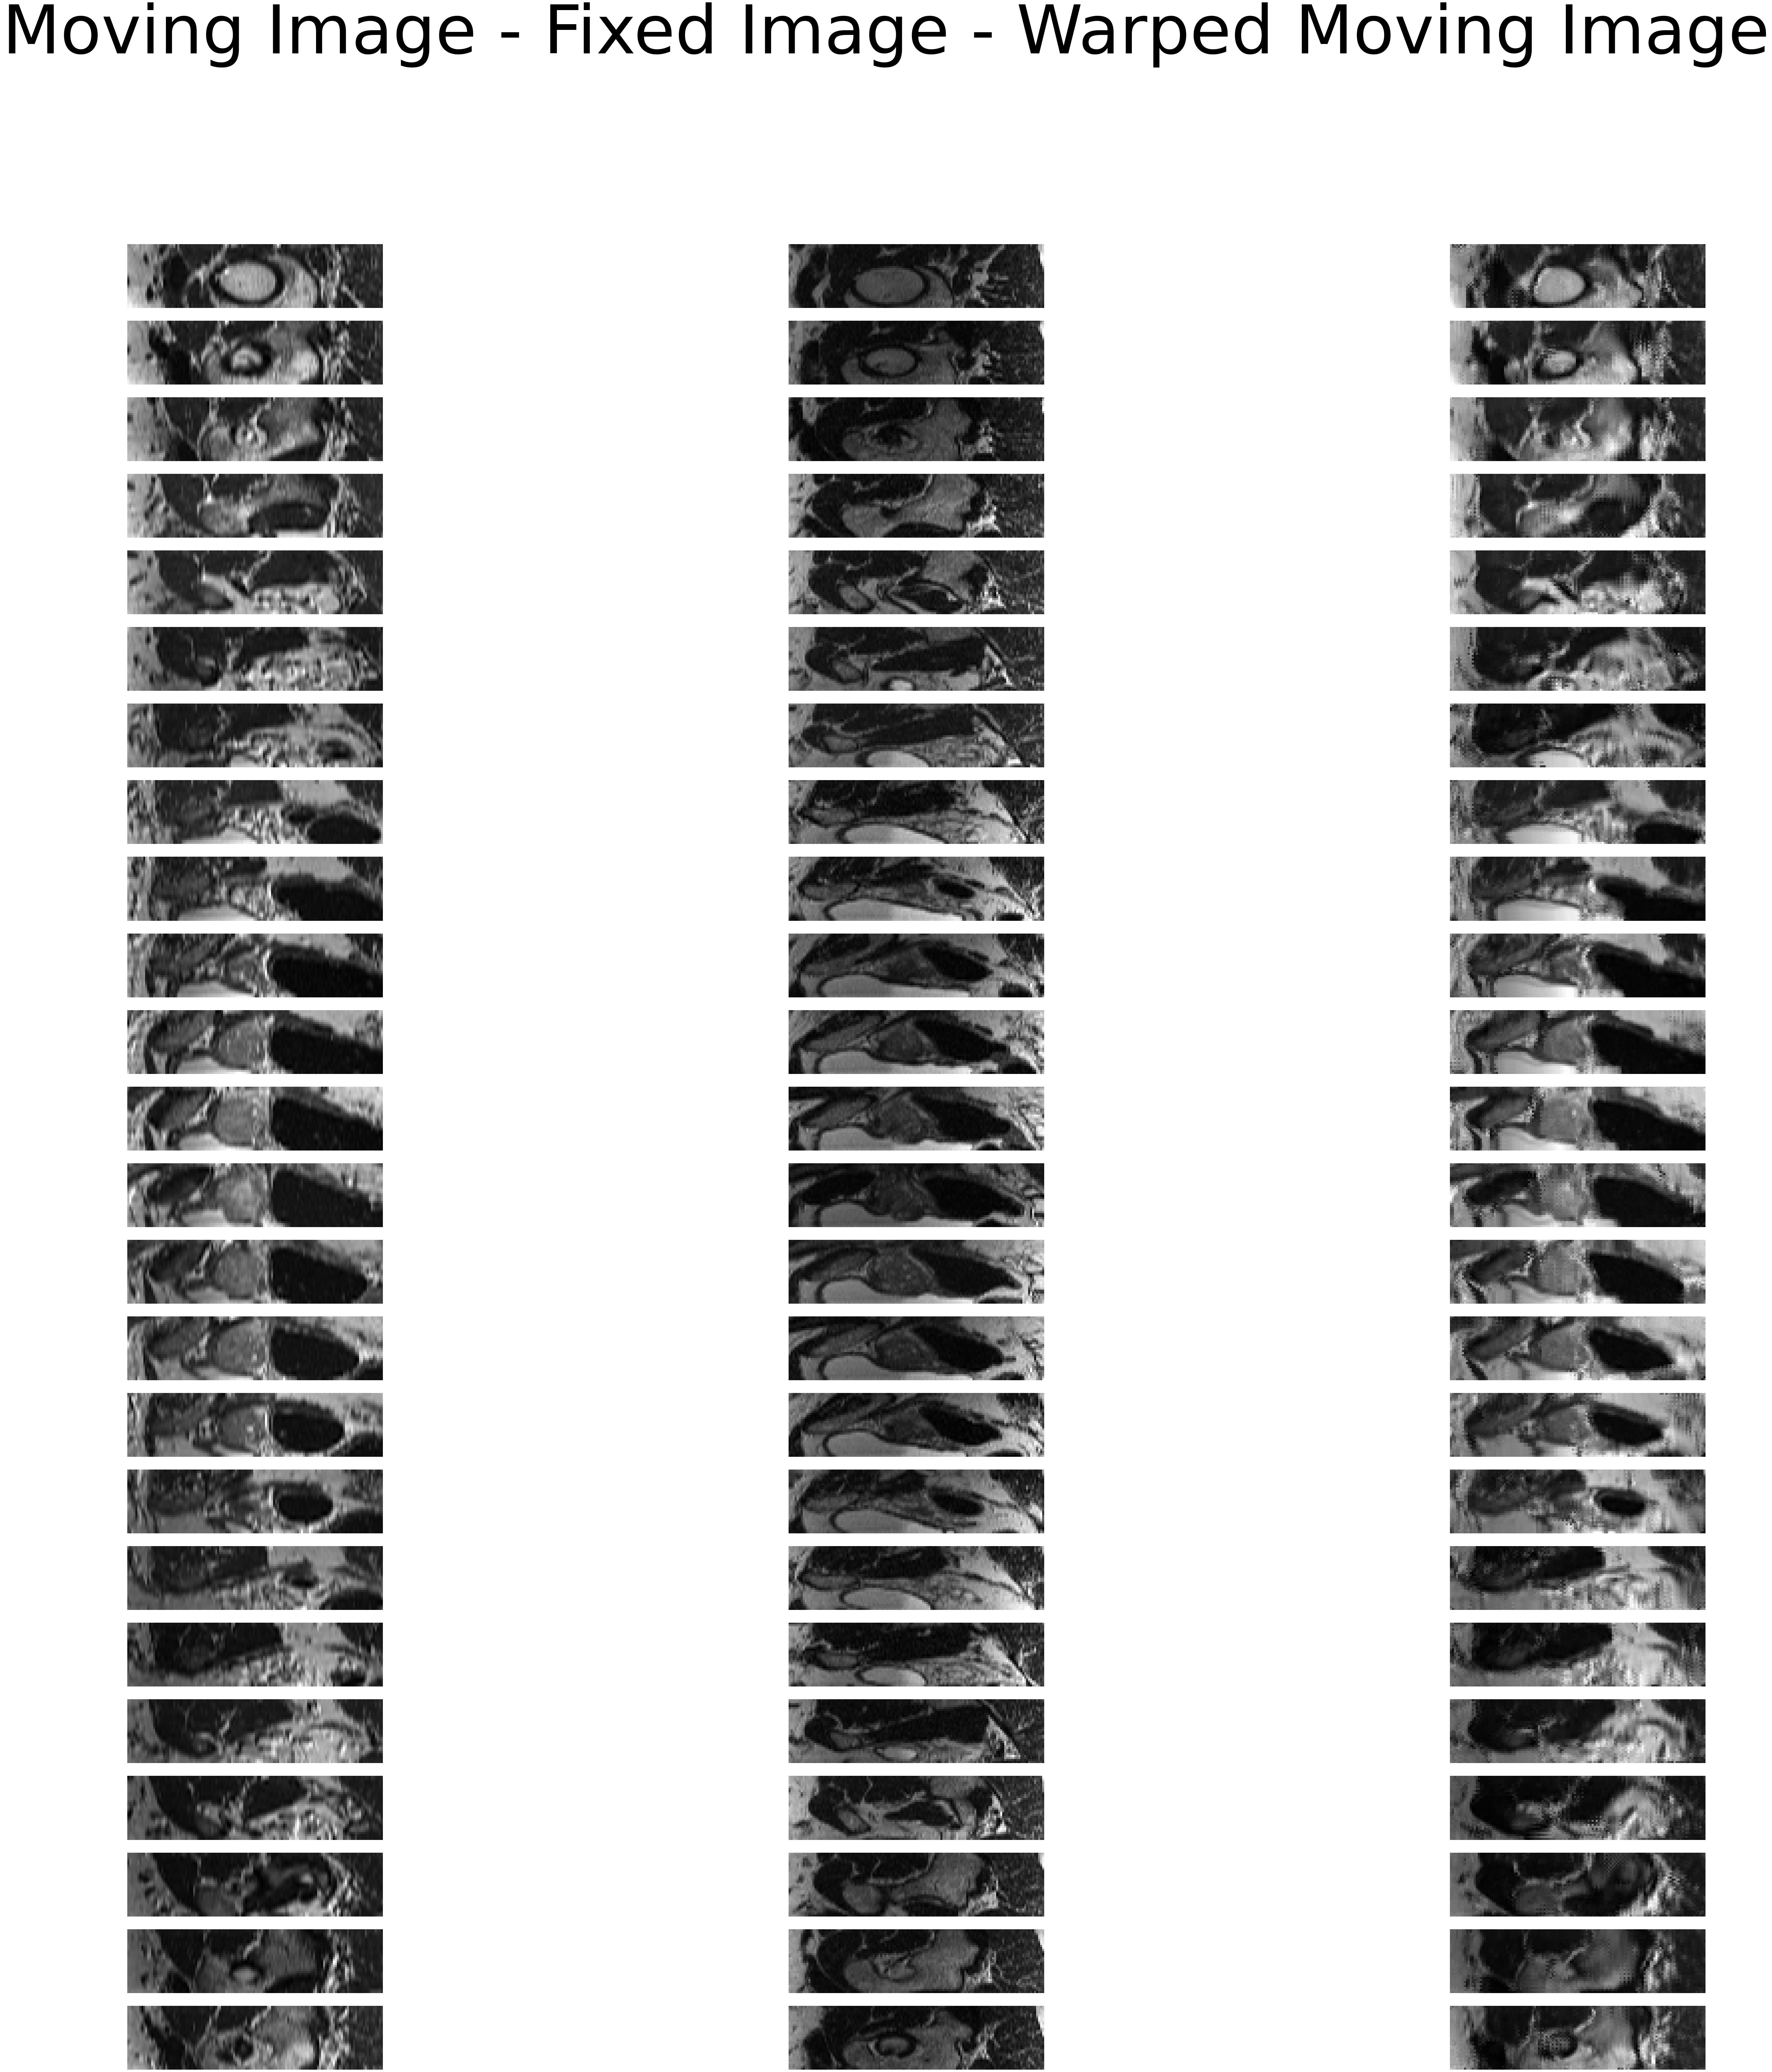

In [72]:
## Warp the moving image using the optimised ddf and the warping layer.
idx_slices = [int(5 + x * 5) for x in range(int(fixed_image_size[3] / 5) - 1)]
nIdx = len(idx_slices)
warped_moving_image = warping(inputs=[var_ddf, moving_image])
plot_results(moving_image, fixed_image, warped_moving_image, nIdx)

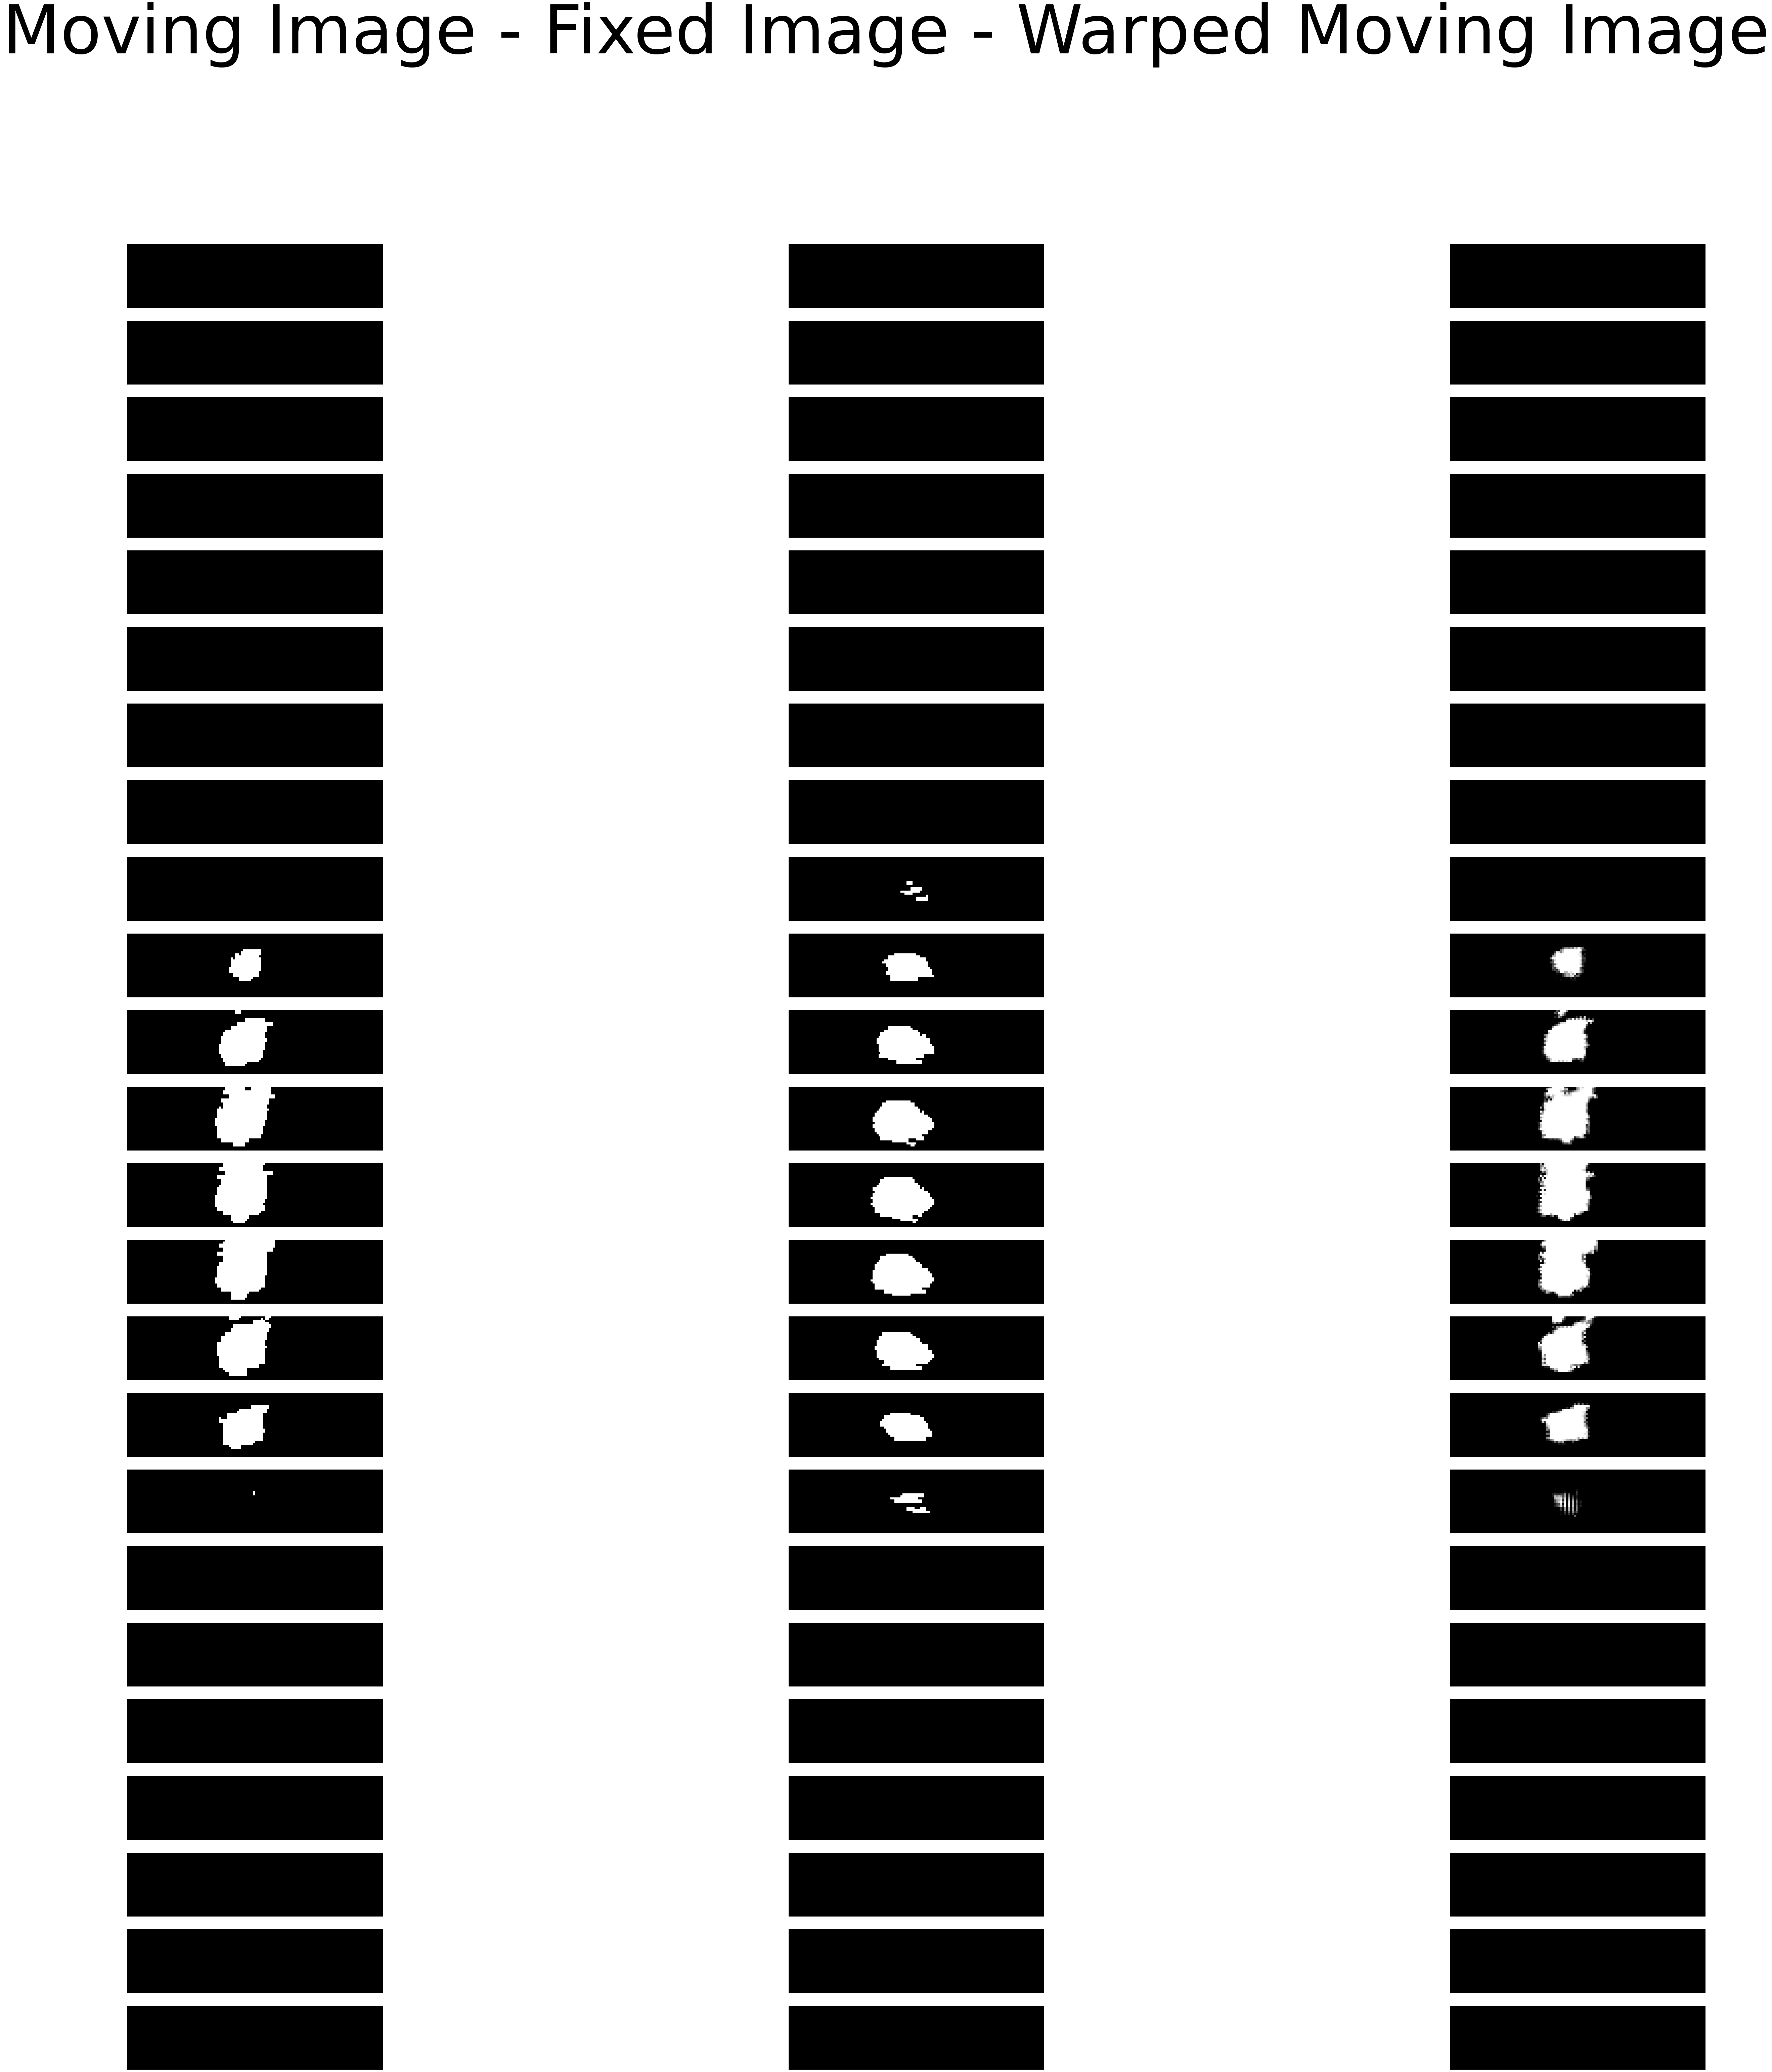

In [74]:
## We can observe the effects of the warping on the moving label using the optimised affine transformation
moving_label = tf.cast(tf.expand_dims(fid["label0"], axis=0), dtype=tf.float32)
fixed_label = tf.cast(tf.expand_dims(fid["label1"], axis=0), dtype=tf.float32)

idx_slices = [int(5 + x * 5) for x in range(int(fixed_image_size[3] / 5) - 1)]
nIdx = len(idx_slices)
warped_moving_labels = warping(inputs=[var_ddf, moving_label])
plot_results(moving_label, fixed_label, warped_moving_labels, nIdx)

# Medical Image registration using an adapted `DeepReg Demo`

Now, we will build a more complex demo to investigate a clinical case.

We will perform an inter-subject registration: aligning ct images from different patients. The images are all acquired at the same timepoint in the breathing cycle for all patients. This kind of registration is useful for determining how one stimulus affects multiple patietns. If a drug or invasive procedure is administered to multiple patients, registering the images from different patients can give medical professsionals a sense of how each patient is responding in comparison to others. An example of such an application can be seen in **[2]**.

The file IO is a bit more involved for this demo. We provide some functions that do most of this for you.

In [ ]:
import os
import random
import shutil
import zipfile
import nibabel as nib
import numpy as np
from tqdm import tqdm

# if wget is installed remove the following line from comment
import wget

# if already in the abc/DeepReg directory then do nothing, otherwise
# use os.chdir(r'abc/DeepReg') before this line
main_path = os.getcwd()
os.chdir(main_path)

######## DOWNLOADING AND UNZIPPING ALL FILES INTO CORRECT PATH ########

project_dir = r"demos/unpaired_ct_lung"
os.chdir(project_dir)

url = "https://zenodo.org/record/3835682/files/training.zip"
print("Downloading... This may take a couple of minutes.")
fname = wget.download(url)

print("The file ", fname, " has successfully been downloaded!")

Downloading... This may take a couple of minutes.
The file  training.zip  has successfully been downloaded!


In [ ]:
data_folder_name = "data"

print(os.getcwd())
if os.path.exists(os.path.join(main_path, project_dir, data_folder_name)) is not True:
    os.makedirs(os.path.join(main_path, project_dir, data_folder_name))

with zipfile.ZipFile(fname, "r") as zip_ref:
    zip_ref.extractall(data_folder_name)

print("Files unzipped!")

os.remove(fname)
os.chdir(main_path)

/content/MICCAI_2020_reg_tutorial/DeepReg/demos/unpaired_ct_lung
Files unzipped!


In [ ]:
# ######## MOVING FILES INTO TRAIN DIRECTORY ########

# The DeepReg Dataloaders require some specific folder structure, which we make now
! pwd
project_dir = "demos/unpaired_ct_lung"
path_to_data_folder = os.path.join(main_path, project_dir, data_folder_name)
path_to_train = os.path.join(main_path, project_dir, data_folder_name, "train")
path_to_test = os.path.join(main_path, project_dir, data_folder_name, "test")
path_to_images_and_labels = os.path.join(
    main_path, project_dir, data_folder_name, "training"
)

labels_fnames = os.listdir(os.path.join(path_to_images_and_labels, "lungMasks"))
images_fnames = os.listdir(os.path.join(path_to_images_and_labels, "scans"))

if os.path.exists(path_to_train) is not True:
    os.makedirs(path_to_train)
    os.makedirs(os.path.join(path_to_train, "fixed_images"))
    os.makedirs(os.path.join(path_to_train, "fixed_labels"))
    os.makedirs(os.path.join(path_to_train, "moving_images"))
    os.makedirs(os.path.join(path_to_train, "moving_labels"))

/content/MICCAI_2020_reg_tutorial/DeepReg


In [ ]:
def moveFilesIntoCorrectPath(
    fnames, path_to_images_and_labels, new_path, suffix, sub_folder_name
):
    os.chdir(os.path.join(path_to_images_and_labels, sub_folder_name))
    for file in fnames:
        if "insp" in file:
            source = file
            destination = os.path.join(path_to_train, "fixed_" + suffix)
            shutil.move(source, destination)
        if "exp" in file:
            source = file
            destination = os.path.join(path_to_train, "moving_" + suffix)
            shutil.move(source, destination)


if os.path.exists(path_to_images_and_labels):

    moveFilesIntoCorrectPath(
        images_fnames, path_to_images_and_labels, path_to_train, "images", "scans"
    )
    moveFilesIntoCorrectPath(
        labels_fnames, path_to_images_and_labels, path_to_train, "labels", "lungMasks"
    )

os.chdir(main_path)

######## MOVING FILES INTO TEST AND VALID DIRECTORY ########

path_to_test = os.path.join(path_to_data_folder, "test")
path_to_valid = os.path.join(path_to_data_folder, "valid")

if os.path.exists(path_to_test) is not True:

    os.mkdir(path_to_test)
    os.mkdir(os.path.join(path_to_test, "fixed_images"))
    os.mkdir(os.path.join(path_to_test, "fixed_labels"))
    os.mkdir(os.path.join(path_to_test, "moving_images"))
    os.mkdir(os.path.join(path_to_test, "moving_labels"))

    ratio_of_test_and_valid_samples = 0.2

    unique_case_names = []
    for file in images_fnames:
        case_name_as_list = file.split("_")[0:2]
        case_name = case_name_as_list[0] + "_" + case_name_as_list[1]
        unique_case_names.append(case_name)
    unique_case_names = np.unique(unique_case_names)

    test_and_valid_cases = random.sample(
        list(unique_case_names),
        int(ratio_of_test_and_valid_samples * len(unique_case_names)),
    )
    test_cases = test_and_valid_cases[
        0 : int(int(ratio_of_test_and_valid_samples * len(unique_case_names) / 2))
    ]
    valid_cases = test_and_valid_cases[
        int(int(ratio_of_test_and_valid_samples * len(unique_case_names) / 2)) + 1 :
    ]

    def moveTestCasesIntoCorrectPath(test_cases, path_to_train, path_to_test):
        folder_names = os.listdir(path_to_train)
        os.chdir(path_to_train)
        for case in test_cases:
            for folder in folder_names:
                file_names = os.listdir(os.path.join(path_to_train, folder))
                for file in file_names:
                    if case in file:
                        os.chdir(os.path.join(path_to_train, folder))
                        source = file
                        destination = os.path.join(path_to_test, folder)
                        shutil.move(source, destination)

    moveTestCasesIntoCorrectPath(test_cases, path_to_train, path_to_test)

    os.mkdir(path_to_valid)
    os.mkdir(os.path.join(path_to_valid, "fixed_images"))
    os.mkdir(os.path.join(path_to_valid, "fixed_labels"))
    os.mkdir(os.path.join(path_to_valid, "moving_images"))
    os.mkdir(os.path.join(path_to_valid, "moving_labels"))

    moveTestCasesIntoCorrectPath(valid_cases, path_to_train, path_to_valid)

######## NAMING FILES SUCH THAT THEIR NAMES MATCH FOR PAIRING ########

# name all files such that names match exactly for training

for folder in os.listdir(path_to_train):
    path_to_folder = os.path.join(path_to_train, folder)
    os.chdir(path_to_folder)
    for file in os.listdir(path_to_folder):
        if "_insp" in file:
            new_name = file.replace("_insp", "")
        elif "_exp" in file:
            new_name = file.replace("_exp", "")
        source = file
        destination = new_name
        os.rename(source, destination)

# name all files such that names match exactly for testing

for folder in os.listdir(path_to_test):
    path_to_folder = os.path.join(path_to_test, folder)
    os.chdir(path_to_folder)
    for file in os.listdir(path_to_folder):
        if "_insp" in file:
            new_name = file.replace("_insp", "")
        elif "_exp" in file:
            new_name = file.replace("_exp", "")
        source = file
        destination = new_name
        os.rename(source, destination)

# name all files such that names match exactly for validation

for folder in os.listdir(path_to_valid):
    path_to_folder = os.path.join(path_to_valid, folder)
    os.chdir(path_to_folder)
    for file in os.listdir(path_to_folder):
        if "_insp" in file:
            new_name = file.replace("_insp", "")
        elif "_exp" in file:
            new_name = file.replace("_exp", "")
        source = file
        destination = new_name
        os.rename(source, destination)

shutil.rmtree(os.path.join(path_to_images_and_labels))
os.chdir(main_path)

######## FOR UNPAIRED WE USE IMAMGES FROM ONE TIMEPOINT ONLY ########

# so now remove fixed_images and fixed_labels
# and rename moving_images to images
# and moving_labels to labels

folders = os.listdir(os.path.join(project_dir, data_folder_name))

for folder in folders:
    shutil.rmtree(os.path.join(project_dir, data_folder_name, folder, "fixed_images"))
    shutil.rmtree(os.path.join(project_dir, data_folder_name, folder, "fixed_labels"))
    os.rename(
        os.path.join(project_dir, data_folder_name, folder, "moving_images"),
        os.path.join(project_dir, data_folder_name, folder, "images"),
    )
    os.rename(
        os.path.join(project_dir, data_folder_name, folder, "moving_labels"),
        os.path.join(project_dir, data_folder_name, folder, "labels"),
    )

print("All files moved and restructured")

os.chdir(main_path)

######## NOW WE RESACLE THE IMAGES TO 255 ########

data_dir = r"demos/unpaired_ct_lung/data"
folders = os.listdir(data_dir)

for folder in folders:
    subfolders = os.listdir(os.path.join(data_dir, folder))
    print("\n Working on ", folder, ", progress:")
    for subfolder in tqdm(subfolders):
        files = os.listdir(os.path.join(data_dir, folder, subfolder))
        for file in files:
            if file.startswith("case_020"):  # this case did not laod correctly
                os.remove(os.path.join(data_dir, folder, subfolder, file))
            else:
                im_data = np.asarray(
                    nib.load(os.path.join(data_dir, folder, subfolder, file)).dataobj,
                    dtype=np.float32,
                )
                if np.max(im_data) > 255.0:
                    im_data = ((im_data + 285) / (3770 + 285)) * 255.0  # rescale image
                    img = nib.Nifti1Image(im_data, affine=None)
                    nib.save(img, os.path.join(data_dir, folder, subfolder, file))
                    if np.max(img.dataobj) > 255.0:
                        print(
                            "Recheck the following file: ",
                            os.path.join(data_dir, folder, subfolder, file),
                        )
                    nib.save(img, os.path.join(data_dir, folder, subfolder, file))

  0%|          | 0/2 [00:00<?, ?it/s]

All files moved and restructured

 Working on  train , progress:


  0%|          | 0/2 [00:00<?, ?it/s]


 Working on  test , progress:


  0%|          | 0/2 [00:00<?, ?it/s]


 Working on  valid , progress:


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


In [ ]:
from deepreg.train import train
! ls
! pwd

######## NOW WE DO THE TRAINING ########

gpu = tf.test.gpu_device_name()
gpu_allow_growth = True
ckpt_path = ""
log_dir = "learn2reg_t2_unpaired_train_logs"

config_path = [
    os.path.join(os.getcwd(), "deepreg/config/test/ddf.yaml"),
     os.path.join(os.getcwd(), "demos/unpaired_ct_lung/unpaired_ct_lung.yaml")
]

# We use
train(
    gpu=gpu,
    config_path=config_path,
    gpu_allow_growth=gpu_allow_growth,
    ckpt_path=ckpt_path,
    log_dir=log_dir,
)

data	 deepreg.egg-info	      demos    logs	       README.md
dataset  deepreg_logo_cornflower.svg  docs     pyproject.toml  setup.py
deepreg  deepreg_logo_purple.svg      LICENSE  pytest.ini      test
/content/MICCAI_2020_reg_tutorial/DeepReg


KeyError: ignored

In [ ]:

from deepreg.predict import predict

######## PREDICTION ########

log_dir = "learn2reg_t2_unpaired_train_logs"
ckpt_path = os.path.join("logs", log_dir, "save", "weights-epoch2.ckpt")

gpu = ""
gpu_allow_growth = False
predict(
    gpu=gpu,
    gpu_allow_growth=gpu_allow_growth,
    ckpt_path=ckpt_path,
    mode="test",
    batch_size=1,
    log_dir=log_dir,
    sample_label="all",
)

# the numerical metrics are saved in the logs directory specified

######## VISUALISATION ########

# Now lets load in a few samples from the predicitons and plot them

# change the following line to the path to image0 label0
path_to_image0_label0 = r""
os.chdir(path_to_image0_label0)

# change image names if different images need to be plotted instead

plt.subplot(3, 2, 1)
label144 = plt.imread("depth144_fixed_label.png")
plt.imshow(label144)
plt.title("Label")
plt.axis("off")

plt.subplot(3, 2, 2)
pred144 = plt.imread("depth144_fixed_pred.png")
plt.imshow(pred144)
plt.title("Prediction")
plt.axis("off")


plt.subplot(3, 2, 3)
label145 = plt.imread("depth145_fixed_label.png")
plt.imshow(label145)
plt.axis("off")

plt.subplot(3, 2, 4)
pred145 = plt.imread("depth145_fixed_pred.png")
plt.imshow(pred145)
plt.axis("off")


plt.subplot(3, 2, 5)
label184 = plt.imread("depth184_fixed_label.png")
plt.imshow(label184)
plt.axis("off")

plt.subplot(3, 2, 6)
pred184 = plt.imread("depth184_fixed_pred.png")
plt.imshow(pred184)
plt.axis("off")

# this is the path where you want to save the visualisation as a png
path_to_save_fig = r""
plt.savefig(os.path.join(path_to_save_fig, "labels_and_preds.png"))

print("Visual representation of predictions saved to path specified")